# Imports

In [1]:
import os
import time
import pickle
import copy
import numpy as np
from importlib import reload
import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
from common import misc
from common.baseclasses import AWA
from common import plotting
from common import numerical_recipes as numrec
from matplotlib import pyplot as plt

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


# Functions to build probes, spectroscopies, and encodings

## Probe builder

In [411]:
a_nm=20
WL_THz_nm=300e3 #300 microns = 1 THz
freq_THz=a_nm/WL_THz_nm
freq0=24*freq_THz
gap0=1
Nsubnodes=4
Nnodes=244

probe_builder_kwargs = dict(a=1,freq=freq0,gap=gap0,closed=False,
                            Nsubnodes=Nsubnodes,Nnodes=Nnodes)
probe_names = ['sphere','ellipsoid','ellipsoid_long','hyperboloid','hyperboloid_blunt']
probe_builder_kwargs = dict([(probe_name,copy.copy(probe_builder_kwargs)) for \
                             probe_name in probe_names])

probe_builder_kwargs['sphere']['geometry'] = 'sphere'
probe_builder_kwargs['sphere']['L'] = 2

probe_builder_kwargs['ellipsoid']['geometry']='ellipsoid'
probe_builder_kwargs['ellipsoid']['L'] = 10

probe_builder_kwargs['ellipsoid_long']['geometry']='ellipsoid'
probe_builder_kwargs['ellipsoid_long']['L'] = 20e3/a_nm
probe_builder_kwargs['ellipsoid_long']['Nnodes']*=2 # Since probe is long, try to match density

probe_builder_kwargs['hyperboloid']['geometry']='hyperboloid'
probe_builder_kwargs['hyperboloid']['L'] = 20e3/a_nm
probe_builder_kwargs['hyperboloid']['taper_angle'] = 15
probe_builder_kwargs['hyperboloid']['Nnodes']*=2 # Since probe is long, try to match density

probe_builder_kwargs['hyperboloid_blunt']=copy.copy(probe_builder_kwargs['hyperboloid'])
probe_builder_kwargs['hyperboloid_blunt']['a']=2

def get_probe(name,recompute=False,overwrite=False,reload=False):

    try:
        if recompute: raise OSError
        if name in PCE.ProbesCollection and not reload: # not instructed to recompute, so try first to load from file
            return PCE.ProbesCollection[name]
        else: #we may get here with `reload=True`
            return PCE.load(name, PCE.Probe, overwrite_probe = overwrite)

    except (KeyError,OSError): pass # we got here if not in probes collection, or could not load from file

    PCE.ProbesCollection.overwrite(overwrite)
    
    # Grab probe from collection if it's already computed (and we don't wish to recompute)
    if name in PCE.ProbesCollection and not recompute:
        return PCE.ProbesCollection[name]

    probe_names = list(probe_builder_kwargs.keys())
    assert name in probe_names, '`name` must be one of: %s'%probe_names
    kwargs=probe_builder_kwargs[name]
    print('Parameters of probe setup:')
    print(kwargs)
    
    P=PCE.Probe(**kwargs,name=name)

    plt.figure()
    P.plot_geometry(ms=4)

    plt.figure()
    P.plot_geometry(ms=4)
    plt.xlim(-1,1)
    plt.ylim(-.5,1.5)

    P.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
                           Nkappas=244*4,kappa_max=10,kappa_min=None,qquadrature=numrec.GL)
    #P.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
    #P.get_self_impedance(recompute=True)
    P.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
    P.plot_eigenrhos()

    try: PCE.save(P,overwrite=overwrite)
    except OSError: pass

    return P

In [3]:
# Test the builder
P = get_probe('ellipsoid',recompute=False,overwrite=True)

<__init__._ProbesCollection.__setitem__>:
	Registering probe "ellipsoid"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid)_Probe.pickle"!


## Spectroscopy calculator

In [4]:
gaps = np.logspace(-1.75,1.5,400)
gap_spectroscopy_kwargs=dict(gaps=gaps,Nmodes=20,sommerfeld=True,basis_gap=0.2,\
                             Nkappas=244*4,qquadrature='GL')

encoding_kwargs=dict(gap0=0.2,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*10,kappa_min=None)

In [5]:
GS = get_probe('ellipsoid').gapSpectroscopy(recompute=False,**gap_spectroscopy_kwargs)

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid)_ProbeGapSpectroscopy.pickle"!


File already exists, no need to save...


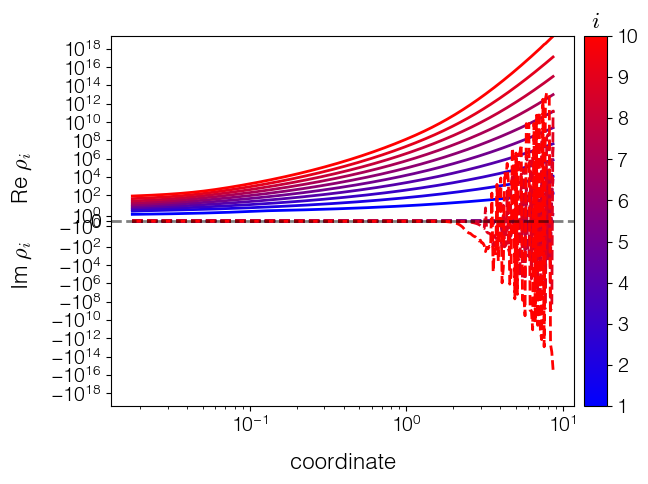

In [6]:
Nmodes_enc = 10
GS.plot_eigenrhos(Nmodes=Nmodes_enc)

try: GS.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

In [7]:
kwargs = copy.copy(encoding_kwargs)
kwargs['Nmodes']=Nmodes_enc
Enc = GS.Encode(recompute=False,**kwargs)

try: Enc.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid)_EncodedEigenfields.pickle"!
File already exists, no need to save...


In [8]:
Enc = GS.Encode(recompute=False,reload=True,**kwargs)

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid)_EncodedEigenfields.pickle"!


# QS sphere probe

## Prepare probe

Parameters of probe setup:
{'a': 1, 'freq': 0.0016, 'gap': 1, 'closed': False, 'Nsubnodes': 2, 'Nnodes': 244, 'geometry': 'sphere', 'L': 2}
<__init__._ProbesCollection.__setitem__>:
	Registering probe "sphere"...
<__init__.Probe.__init__>:
	Generating probe "sphere"...
<RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "sphere"...
<RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 382 annular nodes and 2 subnodes...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix at k=0.01...
	Progress: 99.74%	Total quadrature time: 10.67s, time per quadrature evaluation: 7.31E-05s


<Figure size 640x480 with 0 Axes>

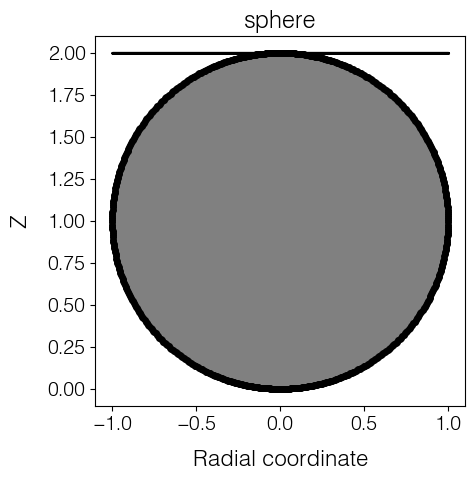

<Figure size 640x480 with 0 Axes>

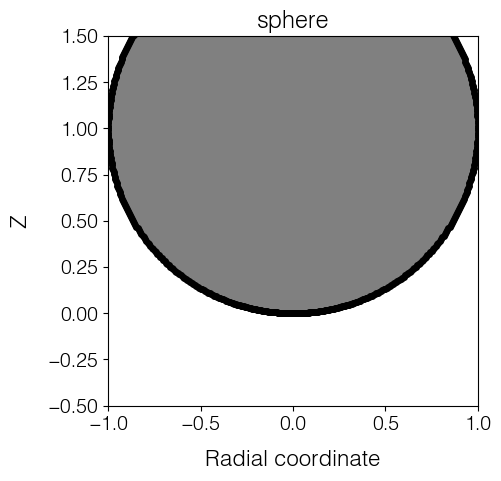

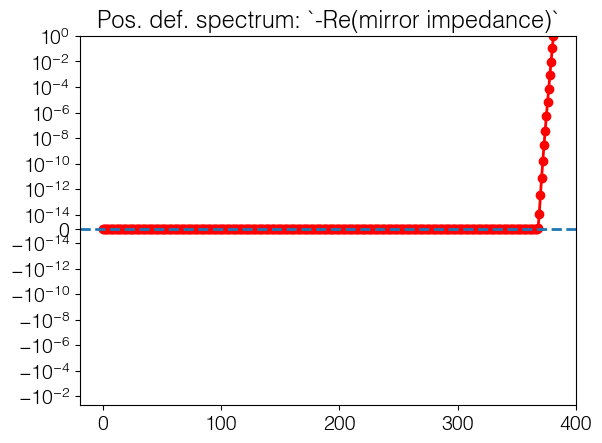

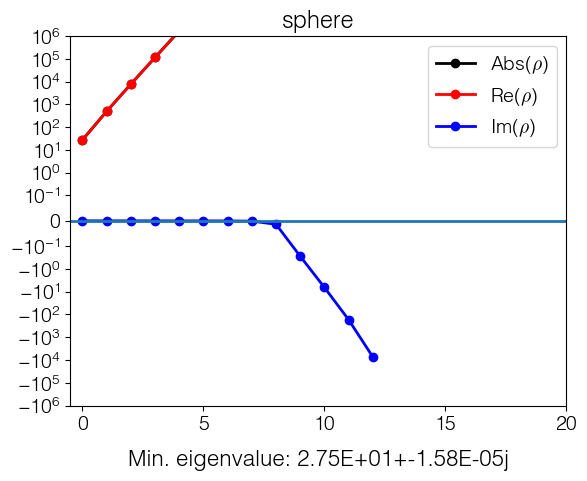

In [15]:
P = get_probe('sphere',recompute=False,overwrite=True)

### Examine radiation pattern

<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness at k=0.01...


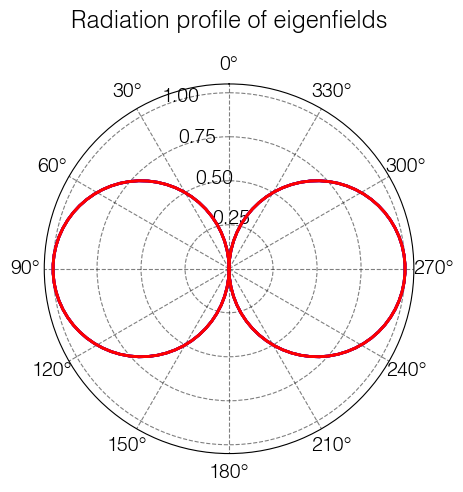

In [11]:
brightnesses=P.get_eigenbrightness(k=None, illum_angles=np.linspace(0, 180, 60),
                                    recompute=True)

N=5
cs = plotting.bluered_colors(N)

fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
for eigenindex in range(N):
    c=next(cs)
    B = np.abs(brightnesses).cslice[:,eigenindex]
    B /= B.max()
    l,=plt.polar(np.deg2rad(B.axes[0]),B,color=c)
    plt.polar(-np.deg2rad(B.axes[0]),B,color=c)

ax.set_theta_zero_location("N")
plt.xticks(np.deg2rad(np.arange(0,360,30)))
plt.title('Radiation profile of eigenfields',pad=20)
ax.set_rticks([0.25,.5,.75, 1])
g=ax.grid(True,ls='--',alpha=.5,color='k')

Phase (rel. pi/2): 0.010204895866128988
Abs: 0.9999999999991768


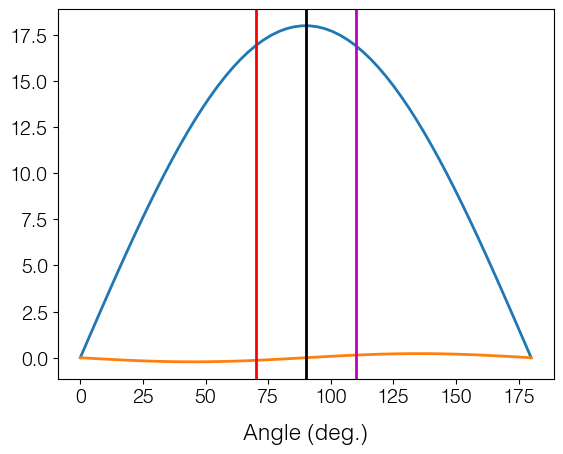

In [12]:
plt.figure()
eigenindex=4
brightnesses.cslice[:,eigenindex].real.plot()
brightnesses.cslice[:,eigenindex].imag.plot()
angle=70; dangle=30
plt.axvline(angle,color='r')
plt.axvline(90,color='k')
plt.axvline(180-angle,color='m')
B1=np.mean(brightnesses.cslice[angle-dangle/2:angle+dangle/2,
                               eigenindex],axis=0)
B2=np.mean(brightnesses.cslice[180-angle-dangle/2:180-angle+dangle/2,
                               eigenindex],axis=0)
print('Phase (rel. pi/2):',np.angle(B2/B1)/(np.pi/2))
print('Abs:',np.abs(B2/B1))

### Examine field at eigenmode

In [13]:
Exc=PCE.EBesselBeamFF()

rho = P.get_eigenrhos()[0]+.01
Q = P.solve_induced_charge_direct(excitation=Exc,\
                                     Vt=None,rho=rho,
                                     Nmodes=20,Veff=True)

rs_out = np.linspace(0,1.5,500)
zs_out = np.linspace(0,3,1000)
Er,Ez = P.computeEfieldImages(Q, rs_out, zs_out, rho=rho,\
                            rp=None, freq=None, Nqs_factor=4,
                            display=True,mirror_double_images=True)

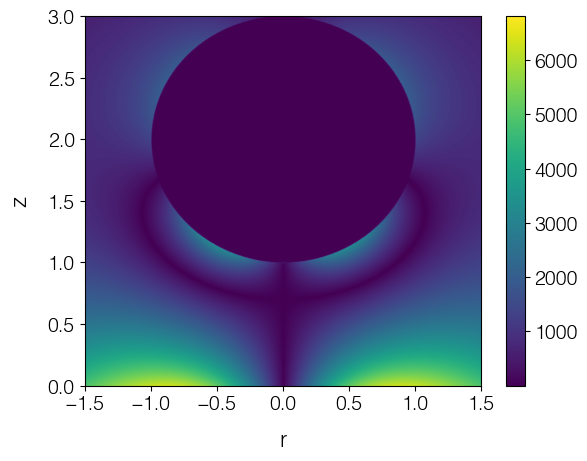

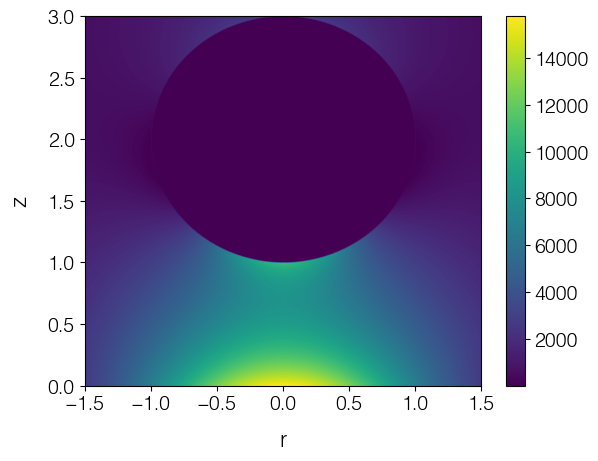

In [14]:
Rs,Zs = Er.axis_grids
Er0,_,Ez0 = Exc(Rs,0,Zs)

np.abs(Er+0*Er0).plot()

plt.figure()
np.abs(Ez+0*Ez0).plot()
#plt.clim(0,1e4)

## Probe spectroscopy

In [16]:
GS = get_probe('sphere').gapSpectroscopy(recompute=False,**gap_spectroscopy_kwargs)

<__init__._ProbesCollection.__setitem__>:
	Overwriting registered probe "sphere"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(sphere)_ProbeGapSpectroscopy.pickle"!


<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 274 identifiable mutual coordinates.
File already exists, no need to save...


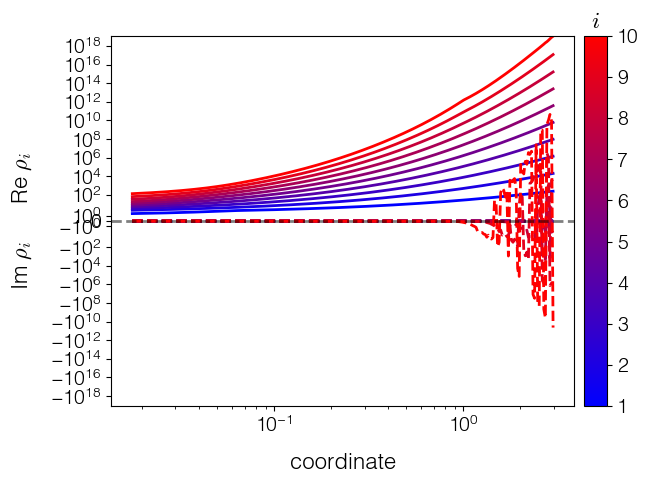

In [17]:
Nmodes_enc = 10
GS.plot_eigenrhos(Nmodes=Nmodes_enc)

try: GS.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

In [18]:
kwargs = copy.copy(encoding_kwargs)
kwargs['Nmodes']=Nmodes_enc
Enc = GS.Encode(recompute=False,**kwargs)

try: Enc.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=10, across  274 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.27%<ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding eigenfields to gap=0.2 across 274 gap values from gap=0.018 to 3...
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.00E-01...
	Updating eigencharges...
	Updating self impedance...
	Updating mirror impedance...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenbrightness_AWA>:
	Computing brightnesses across 274 spectroscopy coordinates...
Successfully saved to file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(sphere)_EncodedEigenfields.pickle"!


## Compare with analytic poles

In [19]:
def SpherePoles(gap,k=0,N=100,rho0=1):

    alpha = np.arccosh(1+gap)
    ms = np.arange(N+1)
    
    from scipy.signal import invres
    
    
    Rs = (2*ms+1)**k
    Ps = np.exp((2*ms+1)*alpha)
    
    Bs,As = invres(Rs,Ps,k=0)
    
    return sorted(np.roots(Bs))

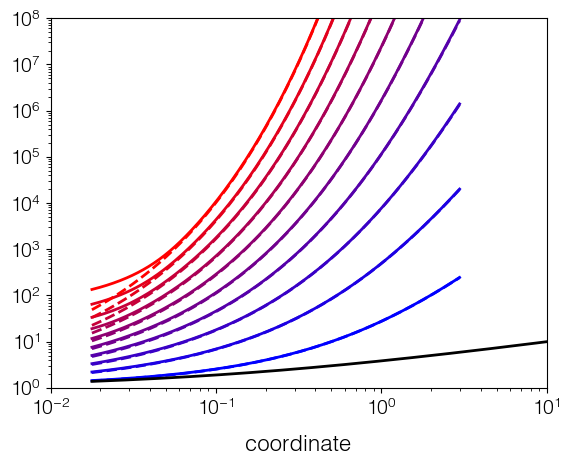

In [20]:
rhos = GS.get_eigenrhos_AWA()
N=len(rhos)

analytic_rhos=np.array([SpherePoles(gap,N=N) for gap in rhos.axes[1]]).T
analytic_rhos = AWA(analytic_rhos,adopt_axes_from=rhos)
    

N=len(rhos)
cs = plotting.bluered_colors(N)
for k,c in enumerate(cs):
    rhos.cslice[k].plot(color=c)
    analytic_rhos.cslice[k].plot(color=c,ls='--')

plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.ylim(1,1e8)
plt.xlim(1e-2,10)

plt.plot(gaps,1+2*np.sqrt(2*gaps),color='k')

# Prepare PCE Model - medium QS ellipsoid

## Prepare probe

Parameters of probe setup:
{'a': 1, 'freq': 0.0016, 'gap': 1, 'closed': False, 'Nsubnodes': 2, 'Nnodes': 244, 'geometry': 'ellipsoid', 'L': 10}
<__init__._ProbesCollection.__setitem__>:
	Registering probe "ellipsoid"...
<__init__.Probe.__init__>:
	Generating probe "ellipsoid"...
<RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "ellipsoid"...
<RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 382 annular nodes and 2 subnodes...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix at k=0.01...
	Progress: 99.74%	Total quadrature time: 10.82s, time per quadrature evaluation: 7.41E-05s


<Figure size 640x480 with 0 Axes>

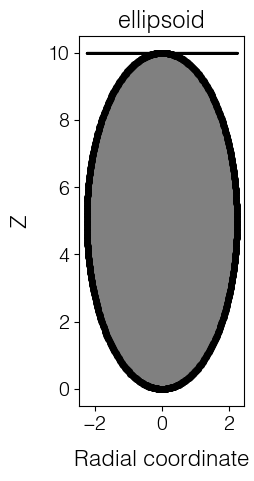

<Figure size 640x480 with 0 Axes>

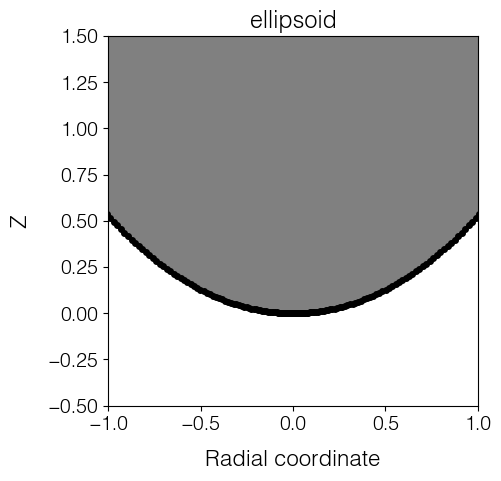

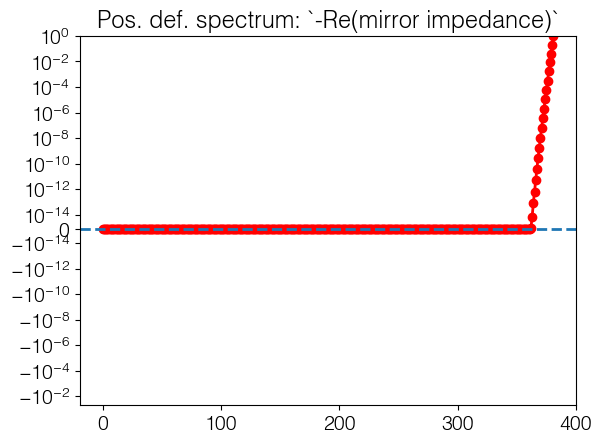

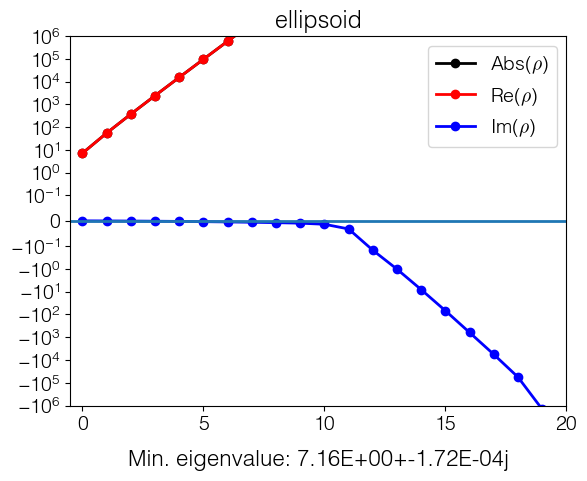

In [21]:
P = get_probe('ellipsoid',recompute=False,overwrite=True)

### Examine radiation pattern

<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness at k=0.01...


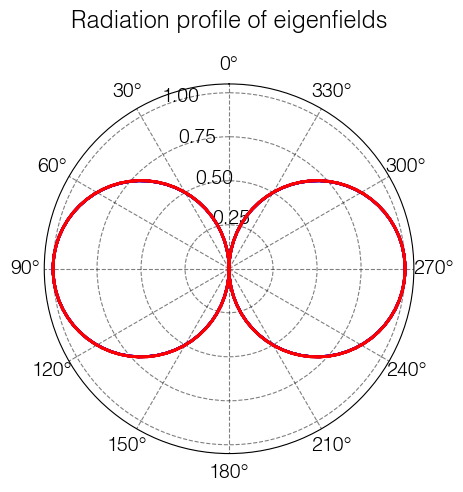

In [23]:
brightnesses=P.get_eigenbrightness(k=None, illum_angles=np.linspace(0, 180, 60),
                                    recompute=True)

N=10
cs = plotting.bluered_colors(N)

fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
for eigenindex in range(N):
    c=next(cs)
    B = np.abs(brightnesses).cslice[:,eigenindex]
    B /= B.max()
    l,=plt.polar(np.deg2rad(B.axes[0]),B,color=c)
    plt.polar(-np.deg2rad(B.axes[0]),B,color=c)

ax.set_theta_zero_location("N")
plt.xticks(np.deg2rad(np.arange(0,360,30)))
plt.title('Radiation profile of eigenfields',pad=20)
ax.set_rticks([0.25,.5,.75, 1])
g=ax.grid(True,ls='--',alpha=.5,color='k')

Phase (rel. pi/2): 0.050108923144477374
Abs: 0.9999999937436943


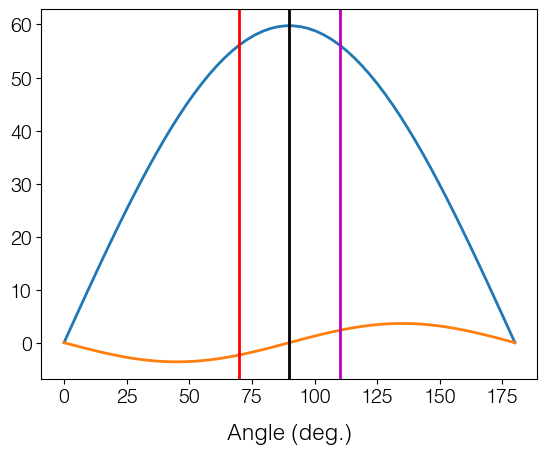

In [24]:
plt.figure()
eigenindex=4
brightnesses.cslice[:,eigenindex].real.plot()
brightnesses.cslice[:,eigenindex].imag.plot()
angle=70; dangle=30
plt.axvline(angle,color='r')
plt.axvline(90,color='k')
plt.axvline(180-angle,color='m')
B1=np.mean(brightnesses.cslice[angle-dangle/2:angle+dangle/2,
                               eigenindex],axis=0)
B2=np.mean(brightnesses.cslice[180-angle-dangle/2:180-angle+dangle/2,
                               eigenindex],axis=0)
print('Phase (rel. pi/2):',np.angle(B2/B1)/(np.pi/2))
print('Abs:',np.abs(B2/B1))

### Examine field at eigenmode

In [25]:
Exc=PCE.EBesselBeamFF()

rho = P.get_eigenrhos()[0]+.01
Q = P.solve_induced_charge_direct(excitation=Exc,\
                                     Vt=None,rho=rho,
                                     Nmodes=20,Veff=True)

rs_out = np.linspace(0,1.5*P.get_radii().max(),500)
zs_out = np.linspace(0,1.1*P.get_zs().max(),1000)
Er,Ez = P.computeEfieldImages(Q, rs_out, zs_out, rho=rho,\
                            rp=None, freq=None, Nqs_factor=4,
                            display=True,mirror_double_images=True)

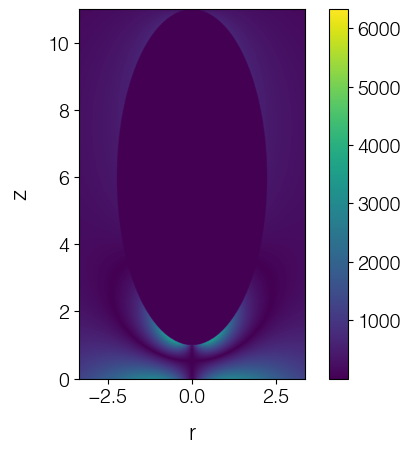

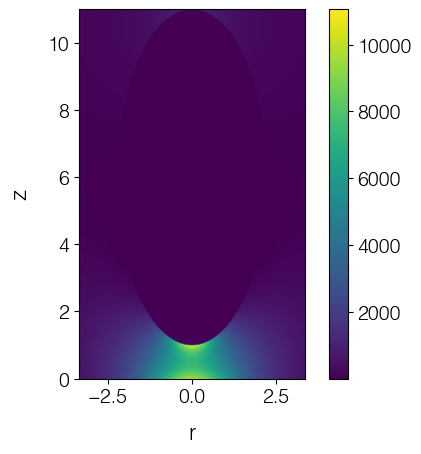

In [28]:
Rs,Zs = Er.axis_grids
Er0,_,Ez0 = Exc(Rs,0,Zs)

np.abs(Er+0*Er0).plot()
plt.gca().set_aspect('equal')

plt.figure()
np.abs(Ez+0*Ez0).plot()
plt.gca().set_aspect('equal')
#plt.clim(0,1e4)

## Probe spectroscopy

In [29]:
GS = get_probe('ellipsoid').gapSpectroscopy(recompute=False,**gap_spectroscopy_kwargs)

We are computing an eigenset at gap=0.20, and using its first 20 modes as a basis for forthcoming calculations!
Starting gap=0.2
<__init__.Probe.reset_eigenproperties>:
	Resetting eigenproperties...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
Finished gap=0.2, elapsed time: 0.66 s
Basis will have length 20
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Paral

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=10, there were 331 identifiable mutual coordinates.
File already exists, no need to save...


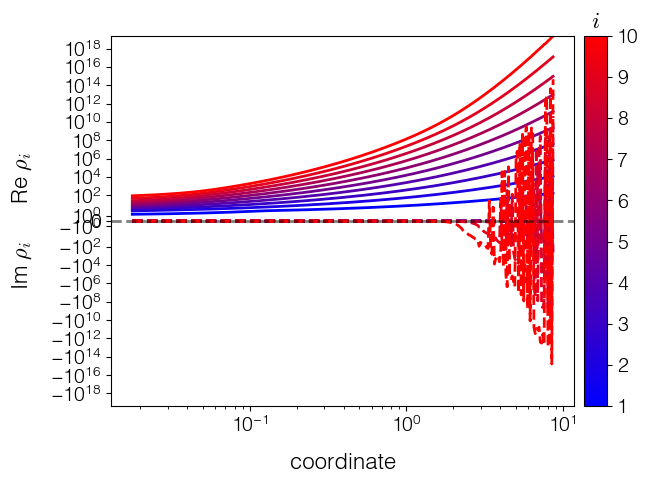

In [33]:
Nmodes_enc = 10
GS.plot_eigenrhos(Nmodes=Nmodes_enc)

try: GS.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

In [31]:
kwargs = copy.copy(encoding_kwargs)
kwargs['Nmodes']=Nmodes_enc
Enc = GS.Encode(recompute=False,**kwargs)

try: Enc.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=10, across  331 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.40%<ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding eigenfields to gap=0.2 across 331 gap values from gap=0.018 to 8.7...
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 2.00E-01...
	Updating eigencharges...
	Updating self impedance...
	Updating mirror impedance...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenbrightness_AWA>:
	Computing brightnesses across 331 spectroscopy coordinates...
Successfully saved to file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid)_EncodedEigenfields.pickle"!


# Prepare PCE Model - long ED ellipsoid

## Prepare probe

In [19]:
probe_name = 'ellipsoid_long'
probe_builder_kwargs[probe_name]['closed']=False  
P = get_probe(probe_name,recompute=False,reload=True,overwrite=True)

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid_long)_Probe.pickle"!


<ProbeCavityEigenfields.Probe.get_eigenbrightness>:
	Computing eigenbrightness at k=0.01...


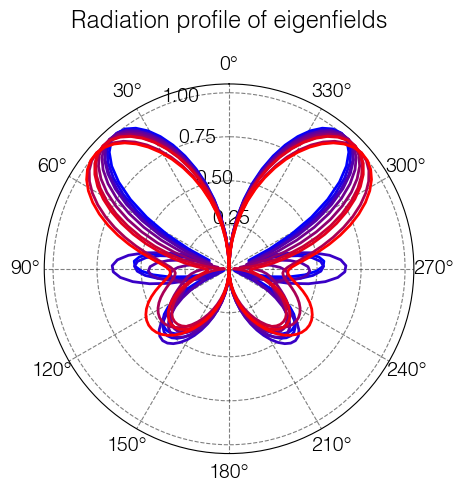

In [685]:
brightnesses=P.get_eigenbrightness(k=None, illum_angles=np.linspace(0, 180, 60),
                                    recompute=True)

N=10
cs = plotting.bluered_colors(N)

fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
for eigenindex in range(N):
    c=next(cs)
    B = np.abs(brightnesses).cslice[:,eigenindex]
    B /= B.max()
    l,=plt.polar(np.deg2rad(B.axes[0]),B,color=c)
    plt.polar(-np.deg2rad(B.axes[0]),B,color=c)

ax.set_theta_zero_location("N")
plt.xticks(np.deg2rad(np.arange(0,360,30)))
plt.title('Radiation profile of eigenfields',pad=20)
ax.set_rticks([0.25,.5,.75, 1])
g=ax.grid(True,ls='--',alpha=.5,color='k')

Phase (rel. pi/2): 1.9287502705968809
Abs: 0.06542940721546521


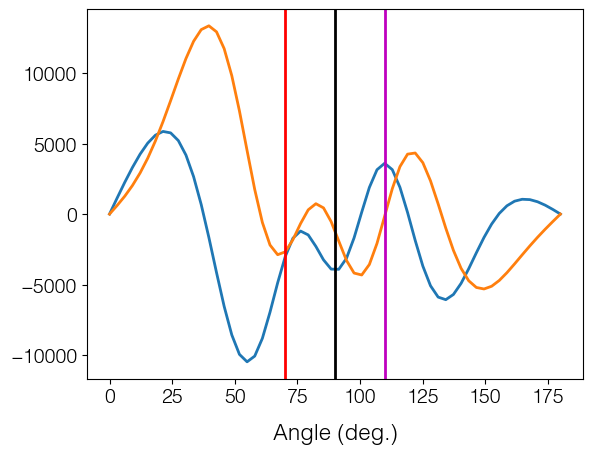

In [686]:
plt.figure()
eigenindex=4
brightnesses.cslice[:,eigenindex].real.plot()
brightnesses.cslice[:,eigenindex].imag.plot()
angle=70; dangle=30
plt.axvline(angle,color='r')
plt.axvline(90,color='k')
plt.axvline(180-angle,color='m')
B1=np.mean(brightnesses.cslice[angle-dangle/2:angle+dangle/2,
                               eigenindex],axis=0)
B2=np.mean(brightnesses.cslice[180-angle-dangle/2:180-angle+dangle/2,
                               eigenindex],axis=0)
print('Phase (rel. pi/2):',np.angle(B2/B1)/(np.pi/2))
print('Abs:',np.abs(B2/B1))

### Examine field at eigenmode

In [687]:
Exc=PCE.EBesselBeamFF()

rho = P.get_eigenrhos()[0]+.01
Q = P.solve_induced_charge_direct(excitation=Exc,\
                                     Vt=None,rho=rho,
                                     Nmodes=20,Veff=True)

rs_out = np.linspace(0,1.5*P.get_radii().max(),500)
zs_out = np.linspace(0,1.1*P.get_zs().max(),1000)
Er,Ez = P.computeEfieldImages(Q, rs_out, zs_out, rho=rho,\
                            rp=None, freq=None, Nqs_factor=4,
                            display=True,mirror_double_images=True)

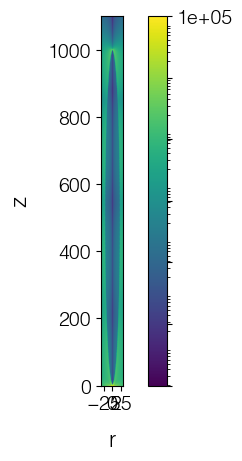

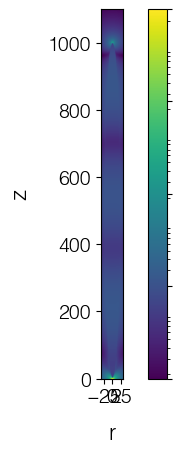

In [688]:
Rs,Zs = Er.axis_grids
Er0,_,Ez0 = Exc(Rs,0,Zs)

np.abs(Er+0*Er0).plot(log_scale=True)
plt.gca().set_aspect('equal')

plt.figure()
np.abs(Ez+0*Ez0).plot(log_scale=True)
plt.gca().set_aspect('equal')
#plt.clim(0,1e4)

## Probe spectroscopy

In [177]:
kwargs = copy.copy(gap_spectroscopy_kwargs)
kwargs['basis_gap']=None
GS = get_probe(probe_name).gapSpectroscopy(reload=False,recompute=True,**kwargs)

	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel calculation retrieved 8 results!
	Parallel c

<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=13, there were 400 identifiable mutual coordinates.
File already exists, no need to save...


(-10000.0, 10000.0)

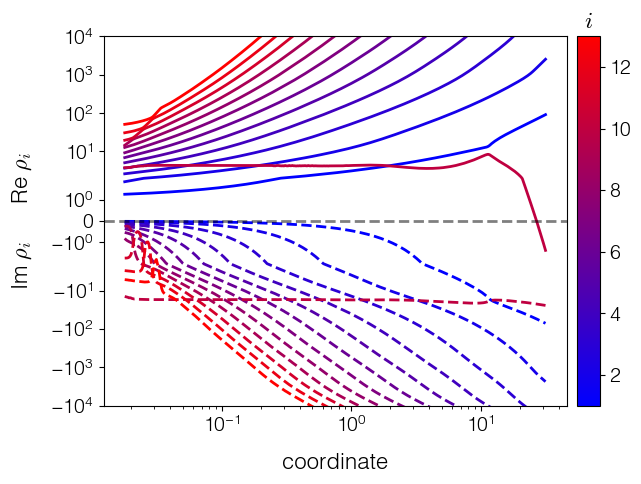

In [191]:
Nmodes_enc = 13
GS.plot_eigenrhos(Nmodes=Nmodes_enc)

try: GS.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

plt.sca(plt.gcf().axes[0])
#plt.xlim(1e-2,1)
plt.ylim(-1e4,1e4)


### Check modes and encode

<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=13, there were 400 identifiable mutual coordinates.
<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=13, across  400 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.50%<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenbrightness_AWA>:
	Computing brightnesses across 400 spectroscopy coordinates...


IndexError: index 13 is out of bounds for axis 0 with size 13

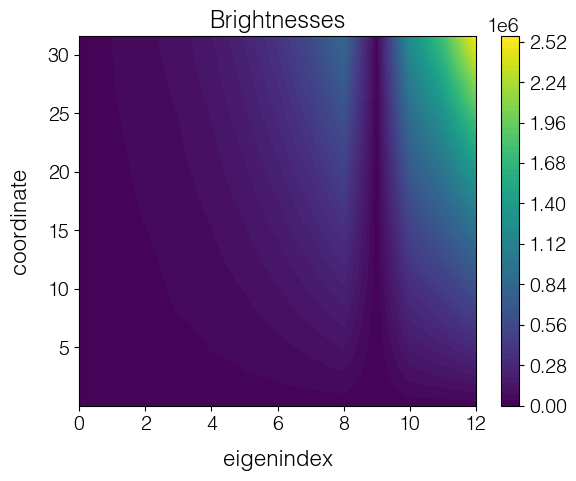

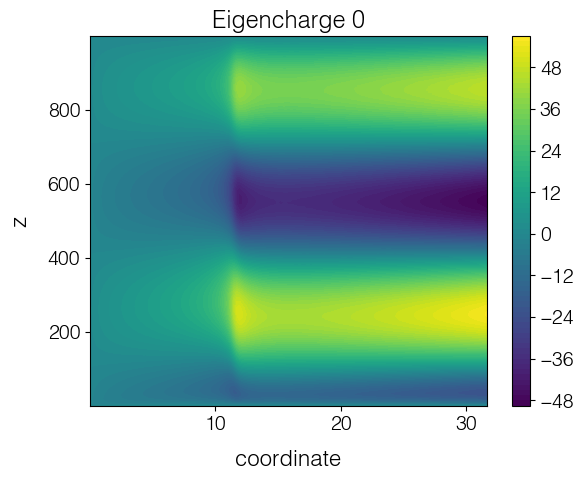

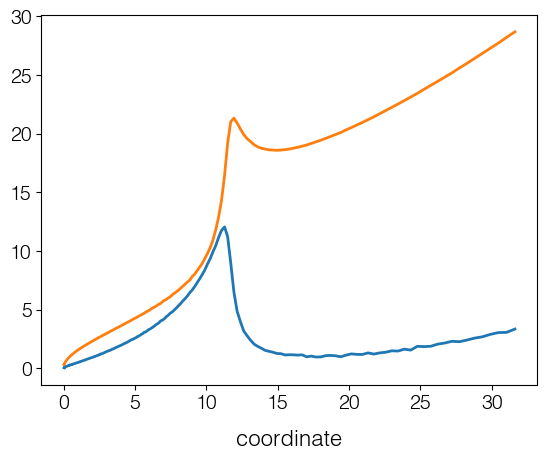

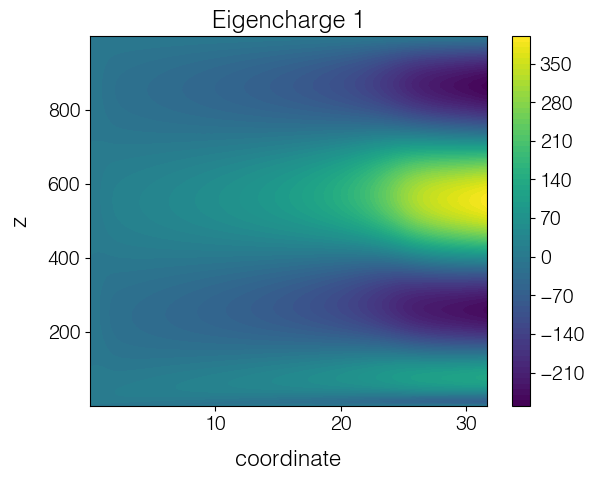

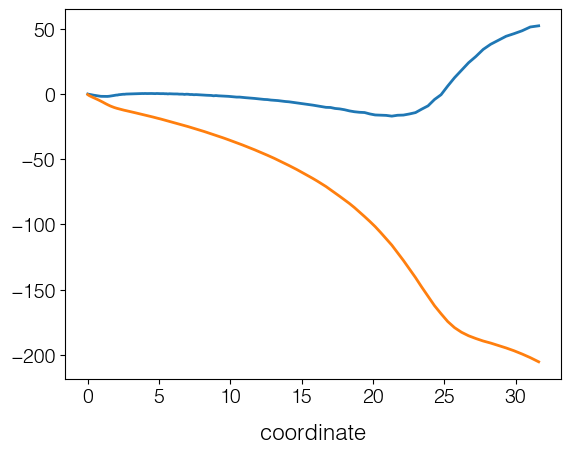

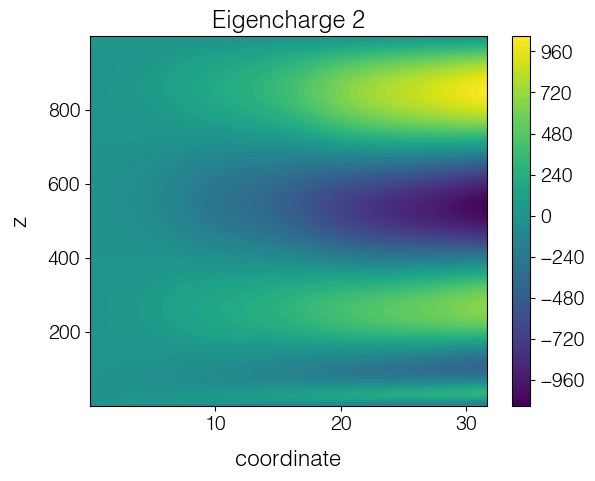

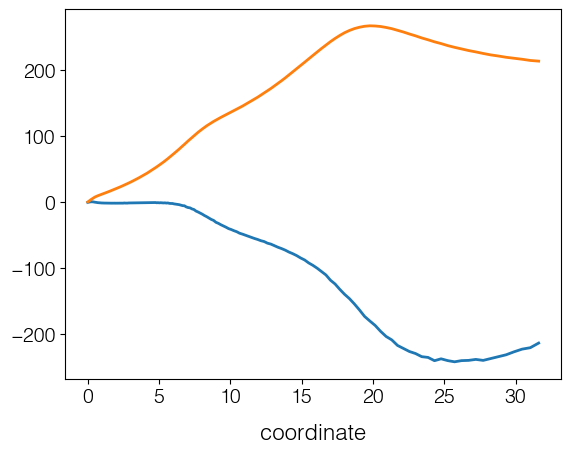

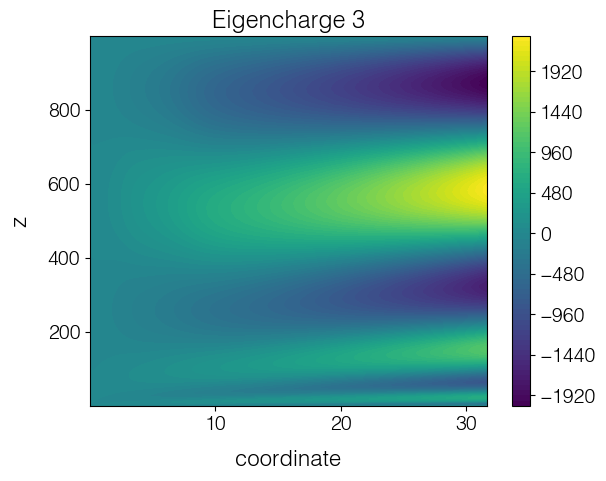

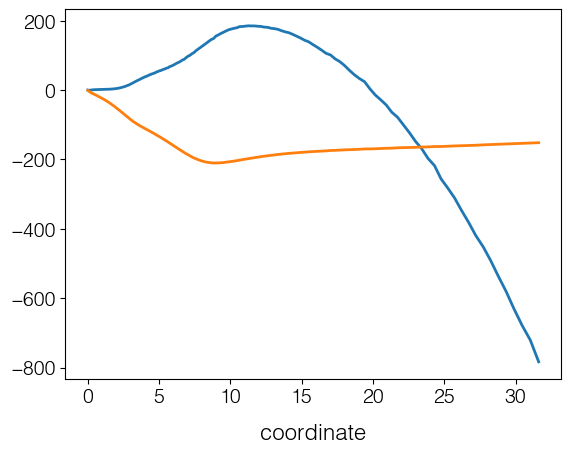

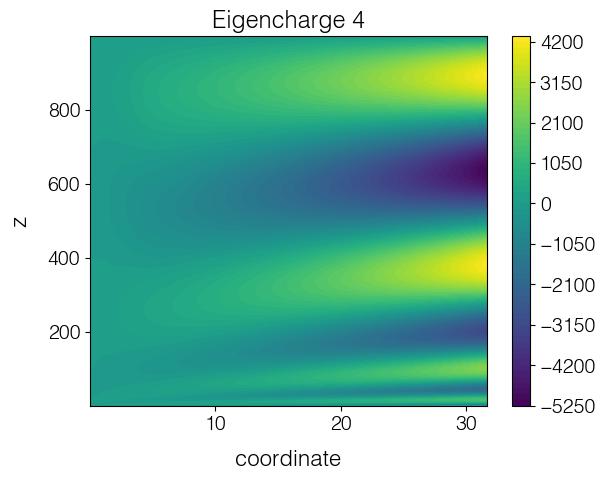

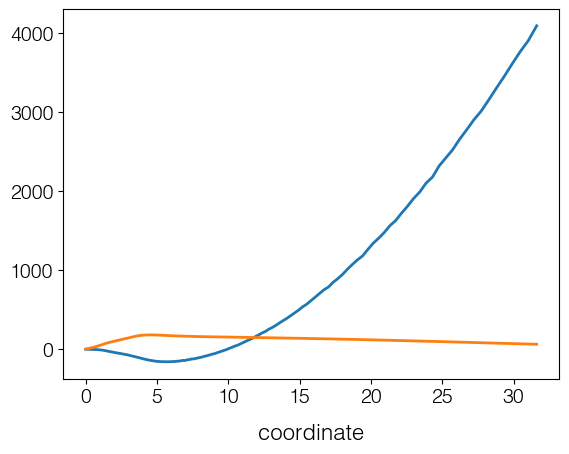

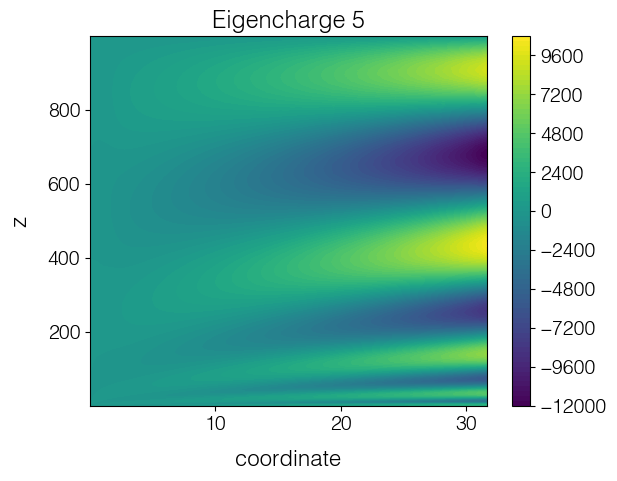

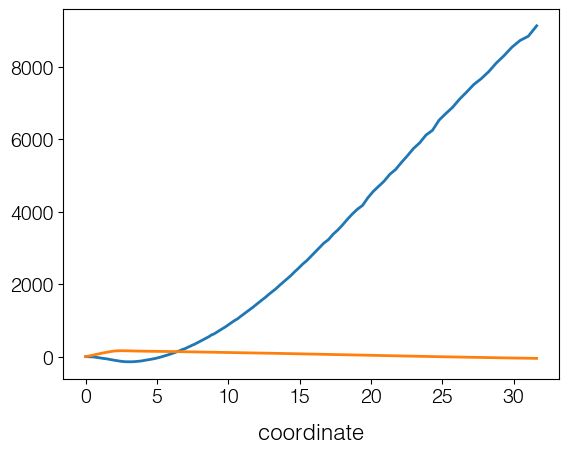

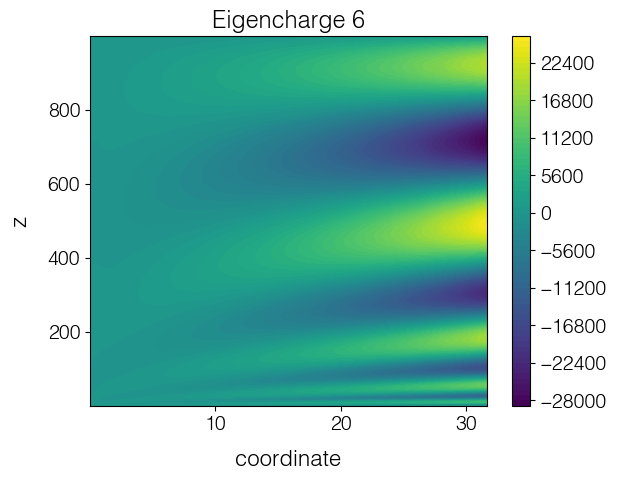

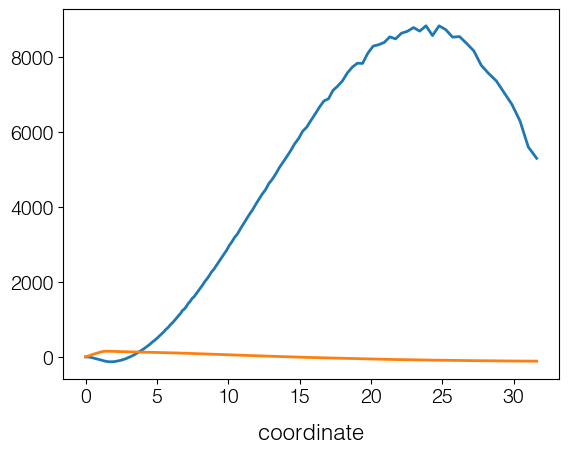

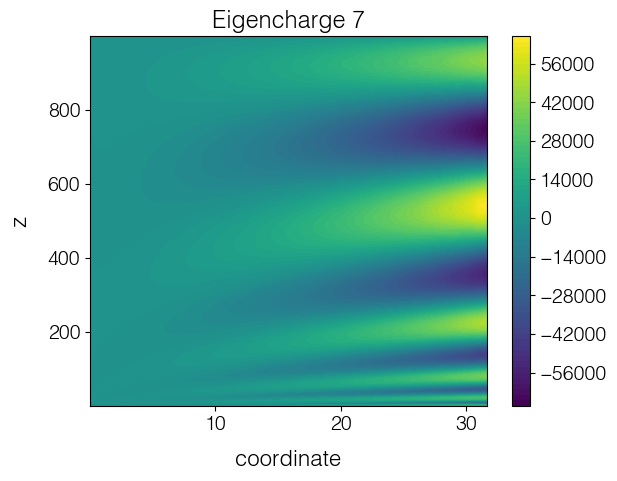

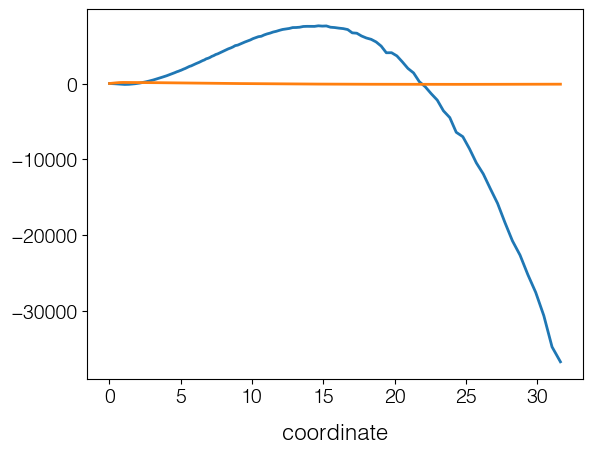

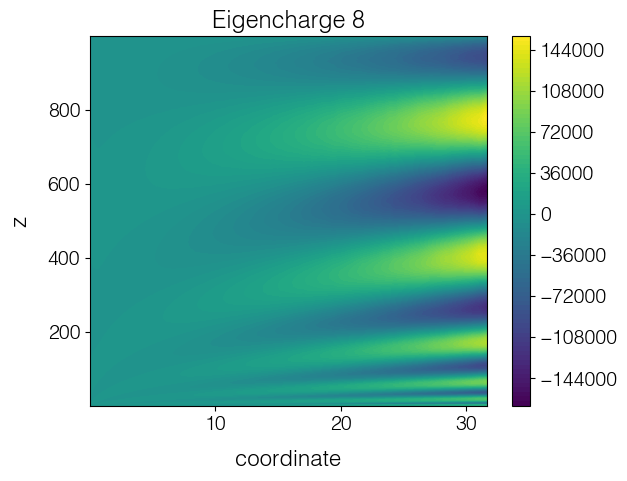

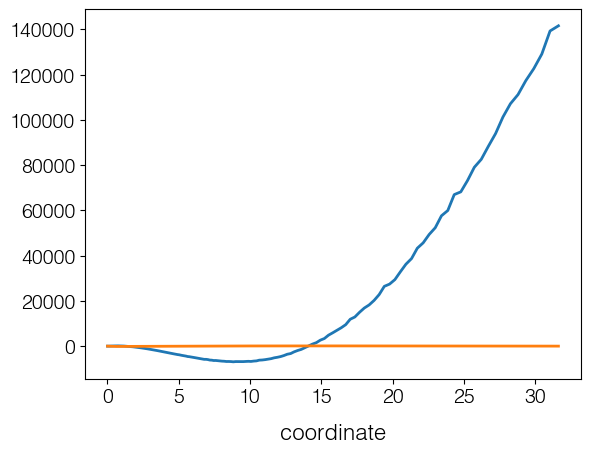

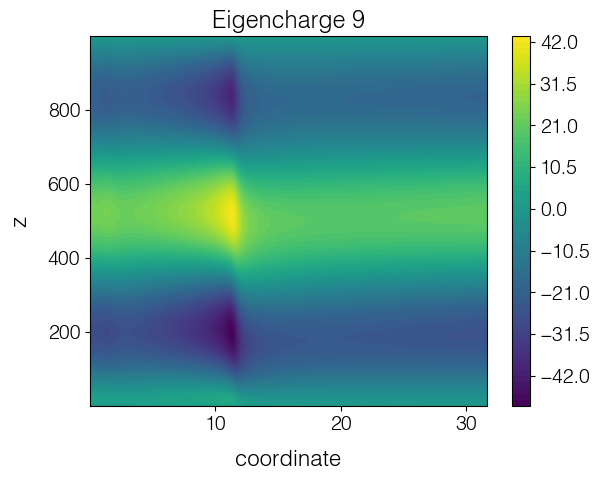

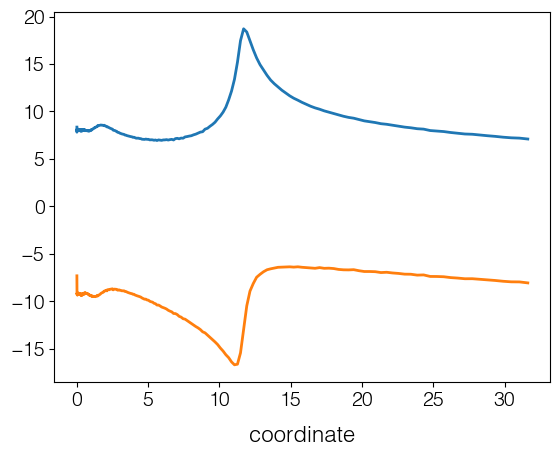

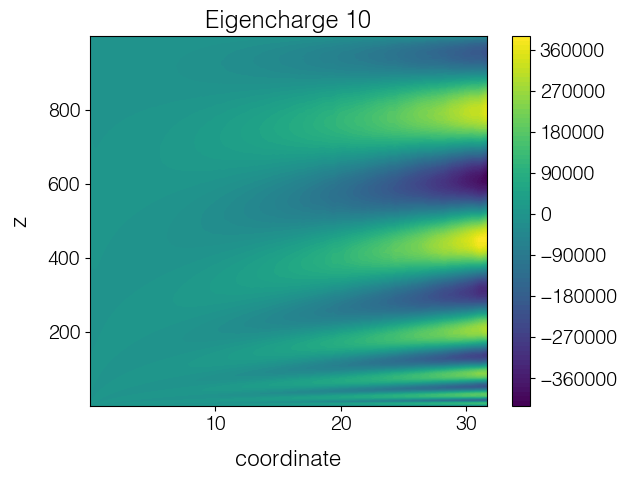

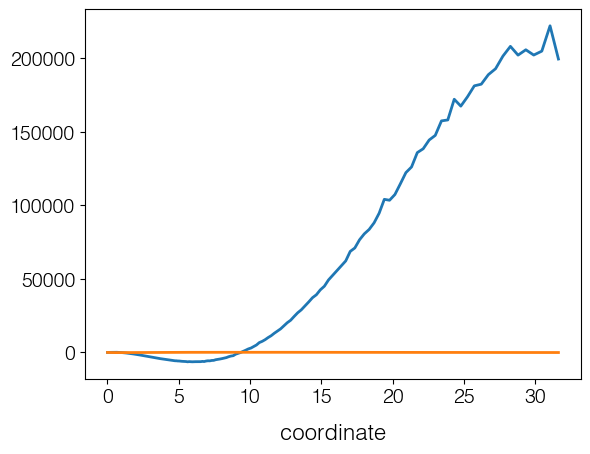

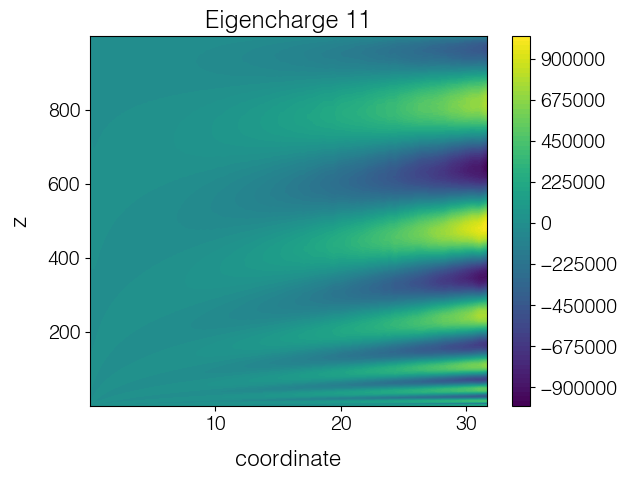

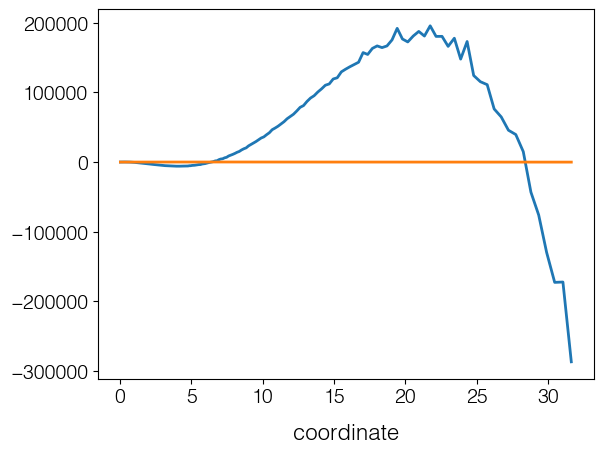

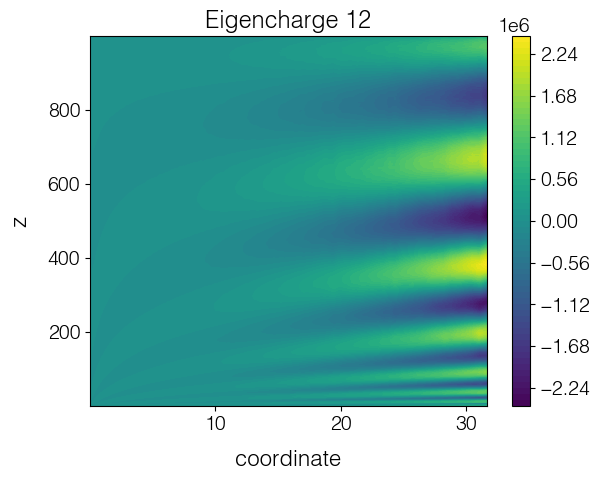

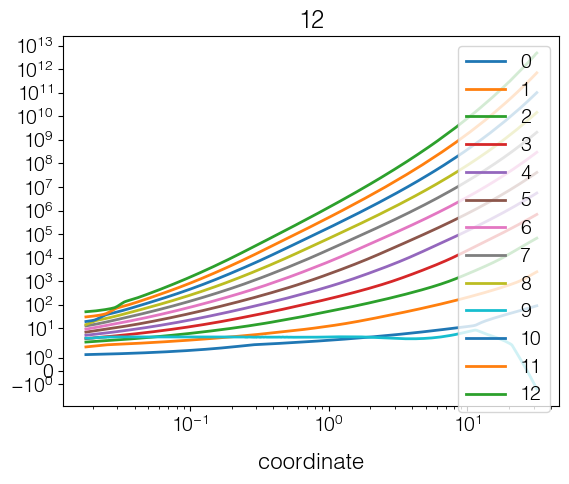

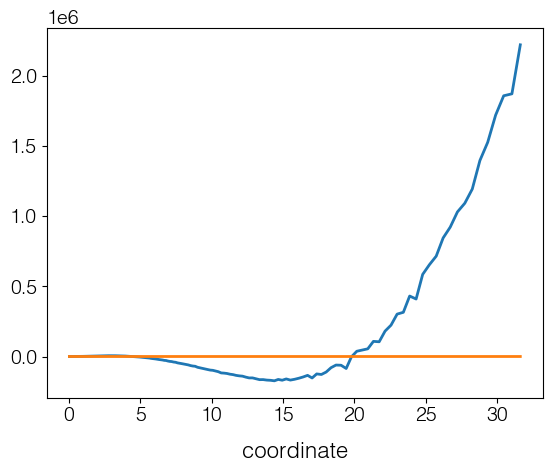

<Figure size 640x480 with 0 Axes>

In [194]:
# Check the modes

rhos = GS.get_eigenrhos_AWA(Nmodes=Nmodes_enc,recompute=True)
charges = GS.get_eigencharges_AWA(Nmodes=Nmodes_enc,recompute=True)
brightnesses=GS.get_eigenbrightness_AWA(Nmodes=Nmodes_enc, recompute=True,
                                eigencharges_AWA=charges)
plt.figure()
np.abs(brightnesses).plot(plotter=plt.contourf)
plt.title('Brightnesses')

for n in np.arange(Nmodes_enc):
    plt.figure()
    Qproblem = charges[n]
    Qproblem.real.plot(plotter=plt.contourf)
    plt.title('Eigencharge %i'%n)
    plt.figure(10)
    rhos[n].real.plot(plotter=plt.semilogx,label=n)
    plt.gca().set_yscale('symlog')
    plt.legend()
    plt.title(n)
    
    plt.figure()
    Qproblem.real.cslice[:,400].plot()
    Qproblem.imag.cslice[:,400].plot()

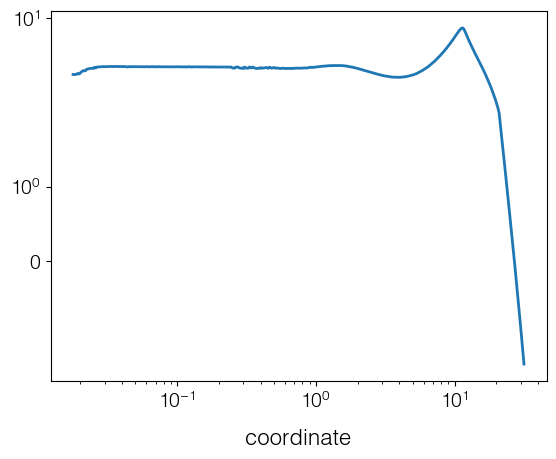

In [196]:
bad_modes=[9]
for bad_mode in bad_modes:
    rhos[bad_mode].real.plot(plotter=plt.semilogx)
plt.gca().set_yscale('symlog')

#keep = [True]*len(rhos)
#for bad_mode in bad_modes: keep[bad_mode]=False

#GS._eigenrhos_AWA = rhos[keep]
#GS._eigencharges_AWA = charges[keep]
#GS._brightnesses_AWA = brightnesses[keep]


In [383]:
kwargs = copy.copy(encoding_kwargs)
kwargs['Nmodes']=Nmodes_enc#-len(bad_modes)
Enc = GS.Encode(recompute=False,reload=True,**kwargs)

try: Enc.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid_long)_EncodedEigenfields.pickle"!
File already exists, no need to save...


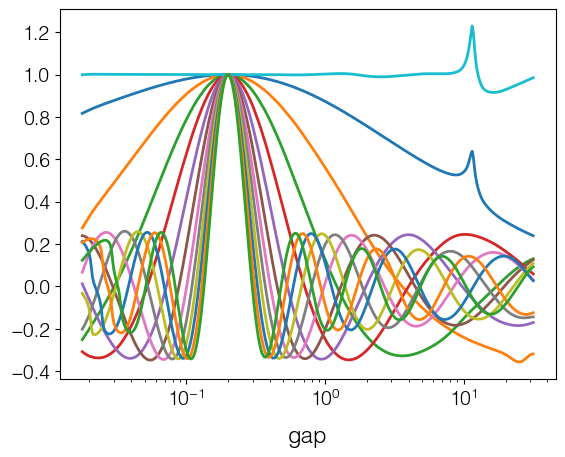

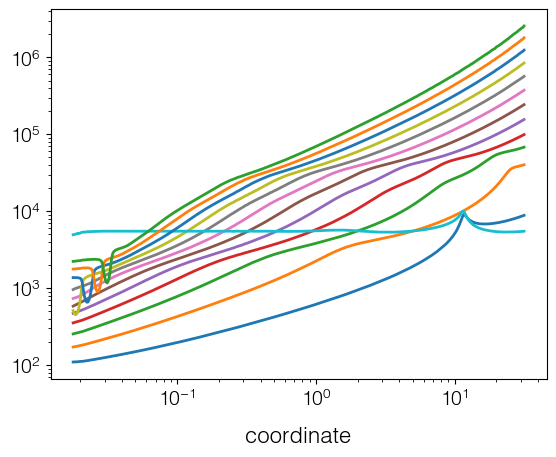

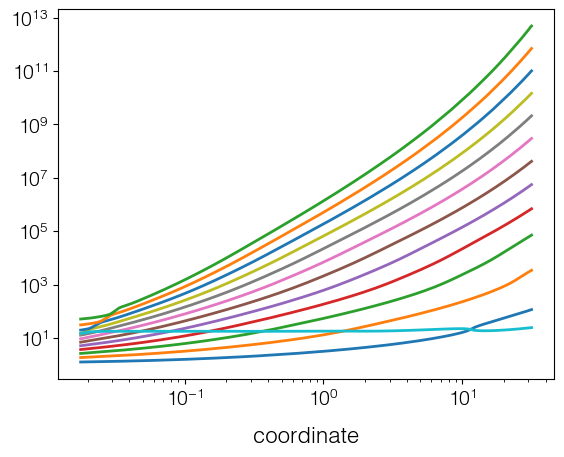

In [384]:
x=Enc.PsiMats_.axes[0]
w = 1/x

for N in range(Nmodes_enc):
    
    s=1e-6
    for M in range(Nmodes_enc):
        Y = Enc.PsiMats_[:,N,M]
        Ysmooth = US(x,Y.real,s=s,w=w)(x) + 1j * US(x,Y.imag,s=s,w=w)(x)
        Enc.PsiMats_[:,N,M] = Ysmooth
        
    plt.figure(1)
    Enc.PsiMats_[:,N,N].real.plot(plotter=plt.semilogx)

    s=1e-5
    Y = Enc.Brightnesses[:,N]
    Ysmooth = US(x,Y.real,s=s,w=w)(x) + 1j * US(x,Y.imag,s=s,w=w)(x)
    Enc.Brightnesses[:,N] = Ysmooth
    
    plt.figure(2)
    np.abs(Enc.Brightnesses[:,N]).plot(plotter=plt.loglog)

    s=1e-5
    Y = Enc.Poles[:,N]
    Ysmooth = US(x,Y.real,s=s,w=w)(x) + 1j * US(x,Y.imag,s=s,w=w)(x)
    Enc.Poles[:,N] = Ysmooth
    
    plt.figure(3)
    np.abs(Enc.Poles[:,N]).plot(plotter=plt.loglog)

(400, 15)


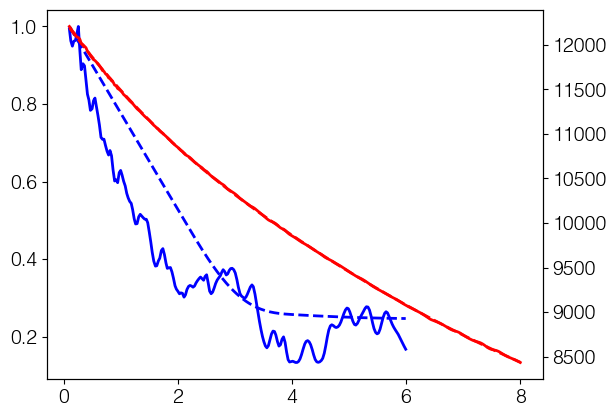

In [408]:
beta=0.1
A=1
zmin,zmax=0.1,8
harmonic=2
Ngaps = 300
at_gaps = np.linspace(zmin,zmax,Ngaps)+1e-3*np.random.randn(Ngaps)
gaps_demod=np.linspace(0,2*A,100)

print(Enc.Poles.shape)
erads = Enc.EradVsGap(at_gaps, freq=.001,rp=beta)

z0s = at_gaps[at_gaps<=zmax-2*A]
sns=[]
for z0 in z0s:
    erads_interp = erads.interpolate_axis(z0+gaps_demod,
                                          axis=0,kind='cubic')
    sn = PCE.demodulate(erads_interp).cslice[harmonic]
    sns.append(sn)
sns = AWA(np.array(sns),axes=[z0s])
sns  /= np.abs(sns).max()

plt.figure()
plt.plot(z0s,np.abs(sns),color='b')
plt.twinx()
plt.plot(at_gaps,np.abs(erads),color='r')

s=1e4
Y = erads; x=at_gaps
Ysmooth = US(x,Y.real,s=s)(x) + 1j * US(x,Y.imag,s=s)(x)
erads = AWA(Ysmooth,axes=[at_gaps])

z0s = at_gaps[at_gaps<=zmax-2*A]
sns=[]
for z0 in z0s:
    erads_interp = erads.interpolate_axis(z0+gaps_demod,
                                          axis=0,kind='cubic')
    sn = PCE.demodulate(erads_interp).cslice[harmonic]
    sns.append(sn)
sns = AWA(np.array(sns),axes=[z0s])
sns  /= np.abs(sns).max()

plt.sca(plt.gcf().axes[0])
plt.plot(z0s,np.abs(sns),color='b',ls='--')
plt.sca(plt.gcf().axes[1])
plt.plot(at_gaps,np.abs(erads),color='r',ls='--')

### Check uniformity of encoding

In [237]:
zmin,zmax = 0.1,10
at_gaps = np.logspace(np.log(zmin)/np.log(10),
                      np.log(zmax)/np.log(10),200)
#at_gaps = np.linspace(.1,10,200) #Doesn't matter, result is robust

Phi0Vecs = np.array(Enc.Phi0Vecs) #column vectors of scalar field vs kappa
BVecs = Enc.BVecs(*at_gaps)
PsiMats = Enc.PsiMats(*at_gaps)
PoleMats = Enc.PoleMats(*at_gaps)

vecs = []
for i,gap in enumerate(at_gaps):
    PoleMat = PoleMats[i]
    PsiMat = PsiMats[i]
    BVec = BVecs[i]
    PoleMatInv = np.diag(1/np.diag(PoleMat))
    # The idea is that radiance vector annhilates eigenfield index,
    # leaving row vector `vec` with columns labeled by q
    # (these q label rows of `Phi0Vecs`, and columns of `Phi0Vecs.T`)
    vec = (BVec.T @ PoleMatInv @ PsiMat.T @ Phi0Vecs.T) # row vector in q, squared
    # We would now have first-order signal:  `Erad = vec @ diag(rp*dkappas) @ vec.T`
    vecs.append( vec.squeeze()**2*Enc.dkappas )

vecs = AWA(vecs,axes=[at_gaps,Enc.kappas],axis_names=['z','q'])

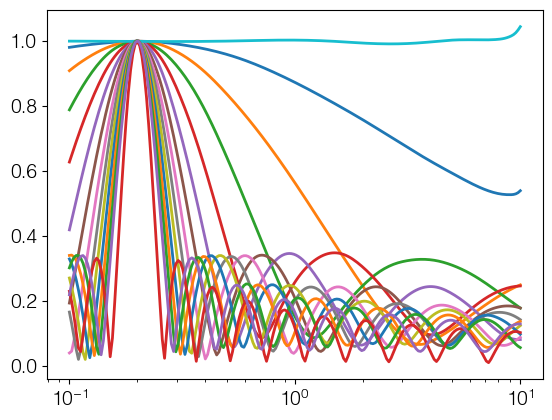

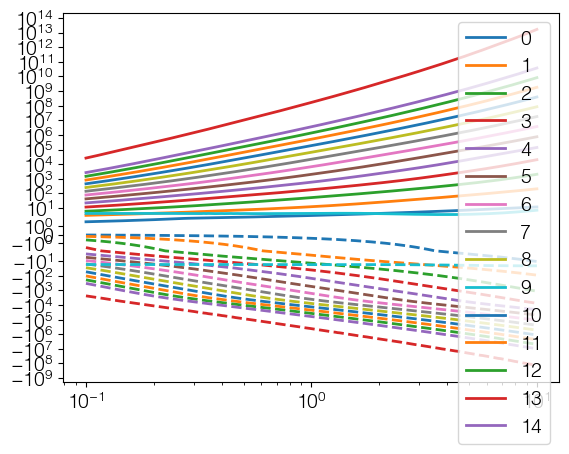

In [238]:
for N in np.arange(0,15):
    plt.figure(1)
    plt.semilogx(at_gaps,np.abs(PsiMats[:,N,N]))
    plt.figure(2)
    l,=plt.semilogx(at_gaps,PoleMats[:,N,N].real,label=N)
    plt.semilogx(at_gaps,PoleMats[:,N,N].imag,color=l.get_color(),ls='--')
    plt.legend()
    plt.gca().set_yscale('symlog')

(1e-07, 1.5)

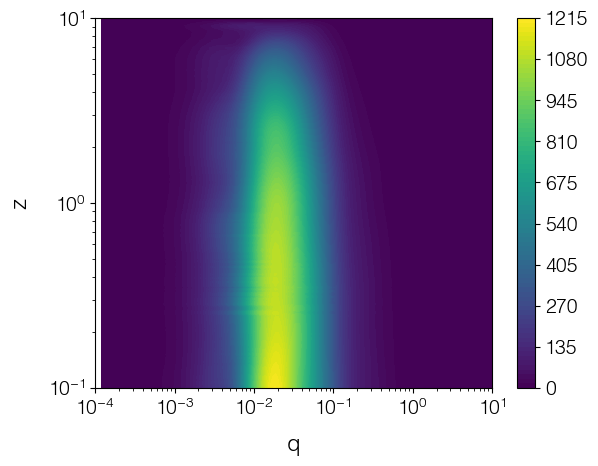

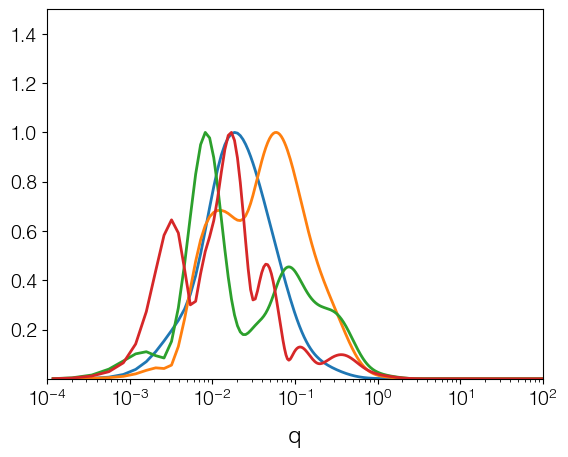

In [239]:
vecs -= vecs[-1][np.newaxis,:]
np.abs(vecs).T.plot(plotter=plt.contourf)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim(1e-4,10)

d = PCE.demodulate(vecs)

plt.figure()
for n in [1,2,3,4]:
    dn=d.cslice[n]
    dn = dn/np.abs(dn).max()
    np.abs(dn).plot()
plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.xlim(1e-4,100)
plt.ylim(1e-7,1.5)

# Prepare PCE Model - long ED hyperboloid

## Prepare probe

Parameters of probe setup:
{'a': 1, 'freq': 0.0016, 'gap': 1, 'closed': False, 'Nsubnodes': 4, 'Nnodes': 488, 'geometry': 'hyperboloid', 'L': 1000.0, 'taper_angle': 15}
<ProbeCavityEigenfields.Probe.__init__>:
	Generating probe "hyperboloid"...
<ProbeCavityEigenfields.RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "hyperboloid"...
<ProbeCavityEigenfields.RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<ProbeCavityEigenfields.RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 766 annular nodes and 4 subnodes...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix at k=0.01...
	Progress: 99.87%	Total quadrature time: 165.32s, time per quadrature evaluation: 2.82E-04s
Successfully saved 

<Figure size 640x480 with 0 Axes>

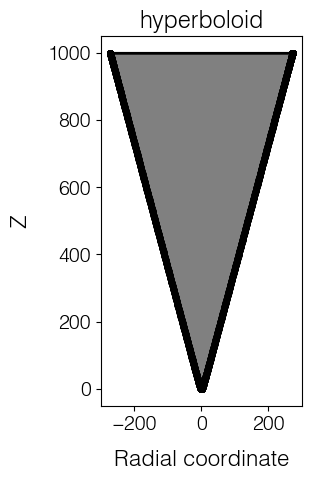

<Figure size 640x480 with 0 Axes>

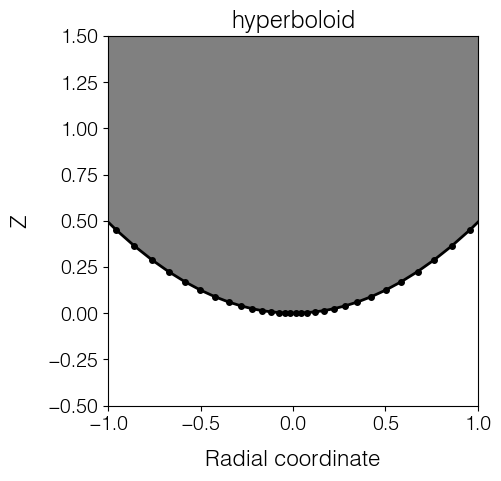

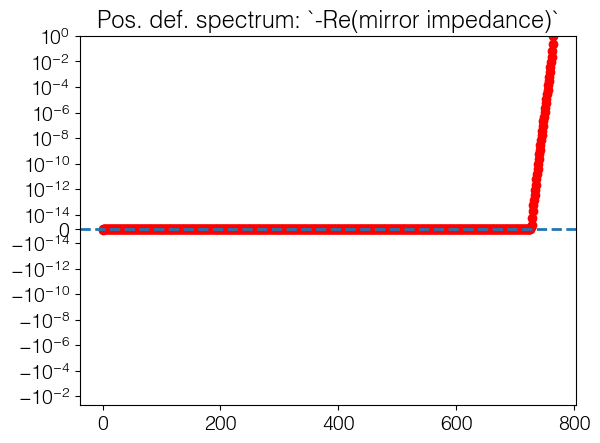

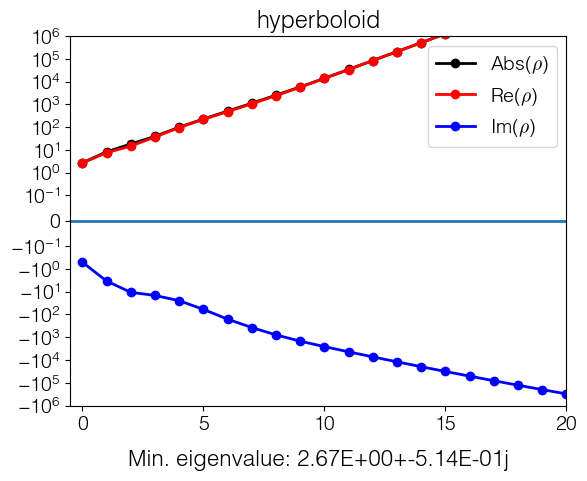

In [670]:
probe_name = 'hyperboloid'
P = get_probe(probe_name,recompute=True,overwrite=True)

Parameters of probe setup:
{'a': 2, 'freq': 0.0016, 'gap': 1, 'closed': False, 'Nsubnodes': 4, 'Nnodes': 488, 'geometry': 'hyperboloid', 'L': 1000.0, 'taper_angle': 15}
<ProbeCavityEigenfields._ProbesCollection.__setitem__>:
	Registering probe "hyperboloid_blunt"...
<ProbeCavityEigenfields.Probe.__init__>:
	Generating probe "hyperboloid_blunt"...
<ProbeCavityEigenfields.RotationalMoM.get_BoR_radii>:
	Getting geometry for selection "hyperboloid"...
<ProbeCavityEigenfields.RotationalMoM.BodyOfRevolution.__init__>:
	Re-meshing provided geometry to quadrature points along annular coordinate `t`...
<ProbeCavityEigenfields.RotationalMoM.BodyOfRevolution.__init__>:
	Discretizing body of revolution over 766 annular nodes and 4 subnodes...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	Including evanescent (near-field) waves..
<ProbeCavityEigenfields.RotationalMoM.ImpedanceMatrix>:
	Preparing dynamic self impedance matrix at k=0.01...
	Progre

<Figure size 640x480 with 0 Axes>

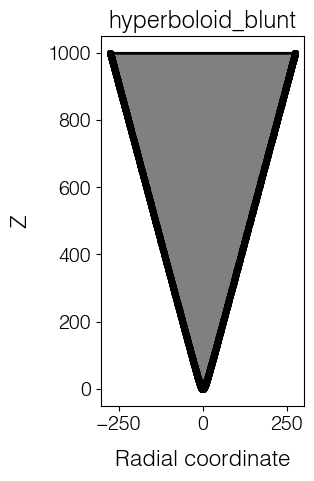

<Figure size 640x480 with 0 Axes>

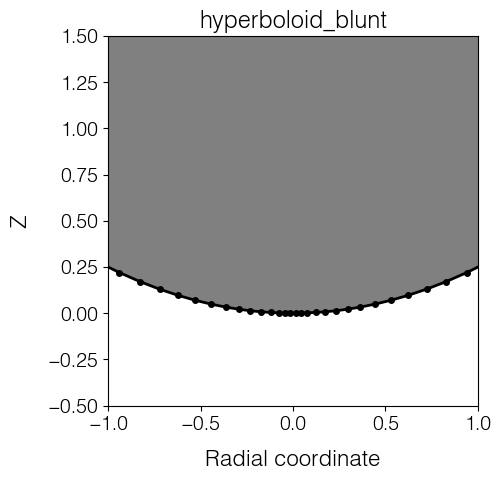

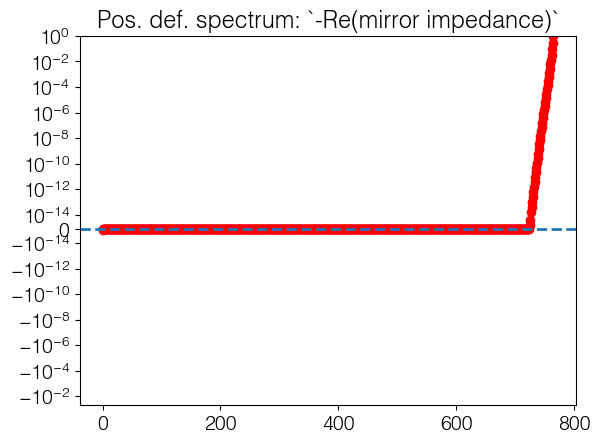

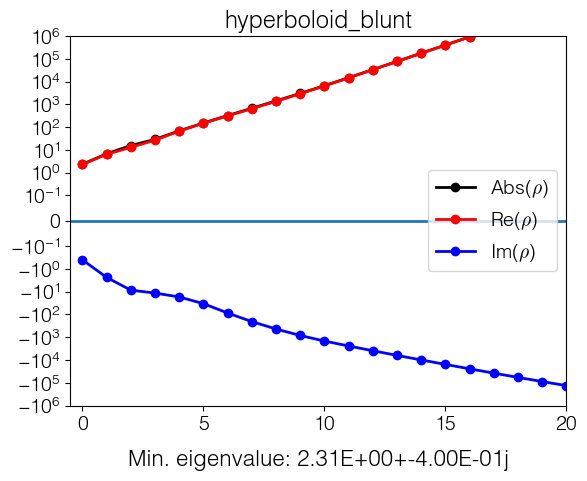

In [412]:
probe_name = 'hyperboloid_blunt'
P = get_probe(probe_name,recompute=True,overwrite=True)

### Examine radiation pattern

<__init__.Probe.get_eigenbrightness>:
	Computing eigenbrightness at k=0.01...


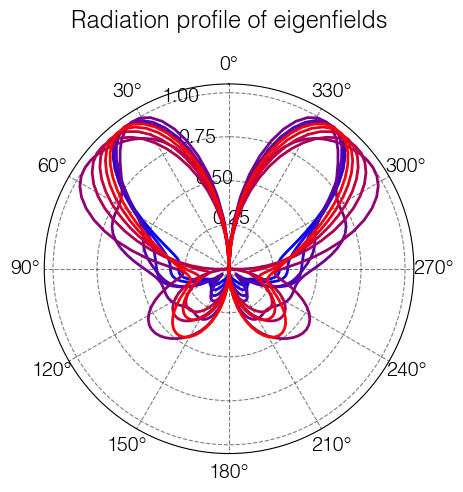

In [10]:
brightnesses=P.get_eigenbrightness(k=None, illum_angles=np.linspace(0, 180, 60),
                                    recompute=True)

N=10
cs = plotting.bluered_colors(N)

fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
for eigenindex in range(N):
    c=next(cs)
    B = np.abs(brightnesses).cslice[:,eigenindex]
    B /= B.max()
    l,=plt.polar(np.deg2rad(B.axes[0]),B,color=c)
    plt.polar(-np.deg2rad(B.axes[0]),B,color=c)

ax.set_theta_zero_location("N")
plt.xticks(np.deg2rad(np.arange(0,360,30)))
plt.title('Radiation profile of eigenfields',pad=20)
ax.set_rticks([0.25,.5,.75, 1])
g=ax.grid(True,ls='--',alpha=.5,color='k')

What is the phase and amplitude from a specular reflection off the sample?
Phase (rel. pi/2): -1.7124833342355323
Abs: 0.3350654818855072


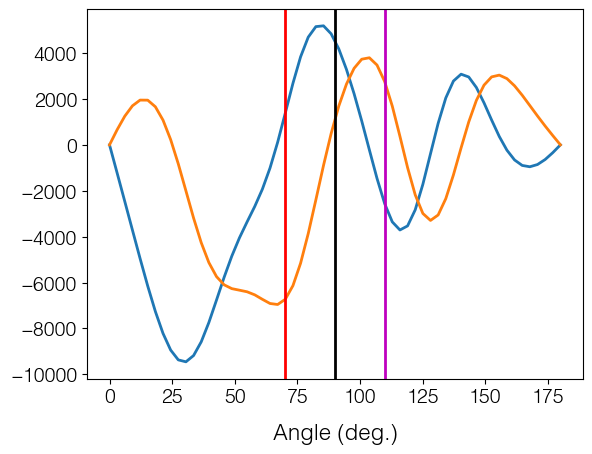

In [11]:
plt.figure()
eigenindex=4
brightnesses.cslice[:,eigenindex].real.plot()
brightnesses.cslice[:,eigenindex].imag.plot()
angle=70; dangle=30
plt.axvline(angle,color='r')
plt.axvline(90,color='k')
plt.axvline(180-angle,color='m')
B1=np.mean(brightnesses.cslice[angle-dangle/2:angle+dangle/2,
                               eigenindex],axis=0)
B2=np.mean(brightnesses.cslice[180-angle-dangle/2:180-angle+dangle/2,
                               eigenindex],axis=0)
print('What is the phase and amplitude from a specular reflection off the sample?')
print('Phase (rel. pi/2):',np.angle(B2/B1)/(np.pi/2))
print('Abs:',np.abs(B2/B1))

### Examine field at eigenmode

In [12]:
Exc=PCE.EBesselBeamFF()

rho = P.get_eigenrhos()[0]+1e-3
Q = P.solve_induced_charge_direct(excitation=Exc,\
                                     Vt=None,rho=rho,
                                     Nmodes=20,Veff=True)

rs_out = np.linspace(0,1.5*P.get_radii().max(),500)
zs_out = np.linspace(0,1.1*P.get_zs().max(),1000)
Er,Ez = P.computeEfieldImages(Q, rs_out, zs_out, rho=rho,\
                            rp=None, freq=None, Nqs_factor=4,
                            display=True,mirror_double_images=True)

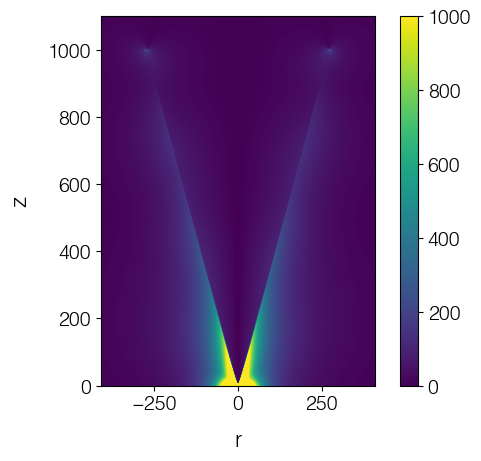

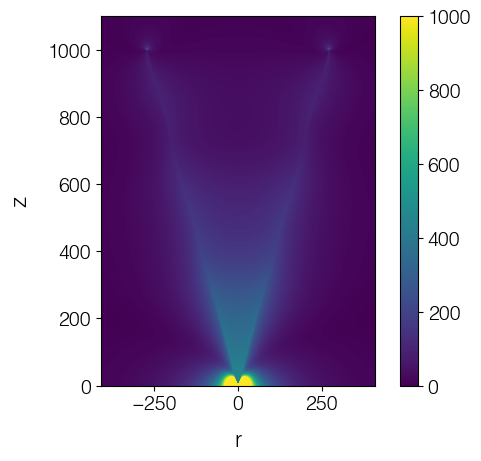

In [14]:
Rs,Zs = Er.axis_grids
Er0,_,Ez0 = Exc(Rs,0,Zs)

np.abs(Er+0*Er0).plot()
plt.gca().set_aspect('equal')
#plt.xlim(-10,10)
#plt.ylim(-1,20)
plt.clim(0,1e3)

plt.figure()
np.abs(Ez+0*Ez0).plot()
plt.gca().set_aspect('equal')
#plt.xlim(-10,10)
#plt.ylim(-1,20)
plt.clim(0,1e3)

## Probe spectroscopy

In [30]:
reload(PS)
kwargs = copy.copy(gap_spectroscopy_kwargs)
kwargs['gaps']=np.logspace(-1.75,1.5,600) # More density, and we'll categorize in reverse
GS = get_probe(probe_name).gapSpectroscopy(recompute=False,reload=True,**kwargs)

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid)_ProbeGapSpectroscopy.pickle"!


Classifying eigensets by eigenindex, with reversal...
	Progress: 99.80%<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=15, there were 490 identifiable mutual coordinates.
File already exists, no need to save...


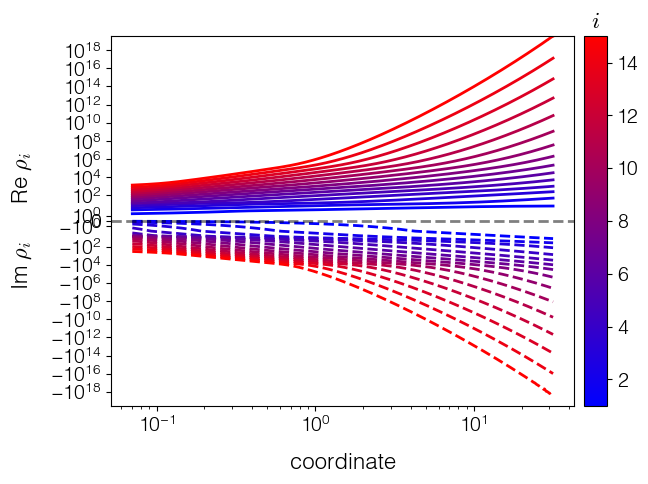

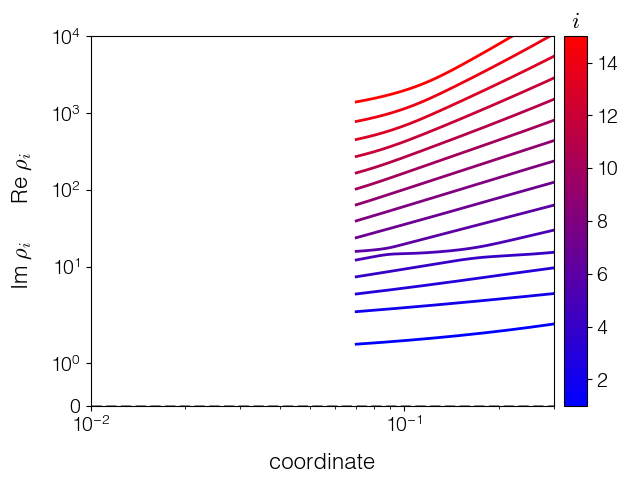

In [31]:
Nmodes_classify = 20
Nmodes_enc = 15
GS(Nmodes=Nmodes_classify, reversed=True, by_rho=False, debug=False,coordmin=.07)
GS.plot_eigenrhos(Nmodes=Nmodes_enc, recompute=True)

plt.figure()
GS.plot_eigenrhos(Nmodes=Nmodes_enc)
plt.sca(plt.gcf().axes[0])
plt.xlim(1e-2,3e-1)
plt.ylim(0,1e4)

try: GS.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=15, across  490 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
	Progress: 99.59%

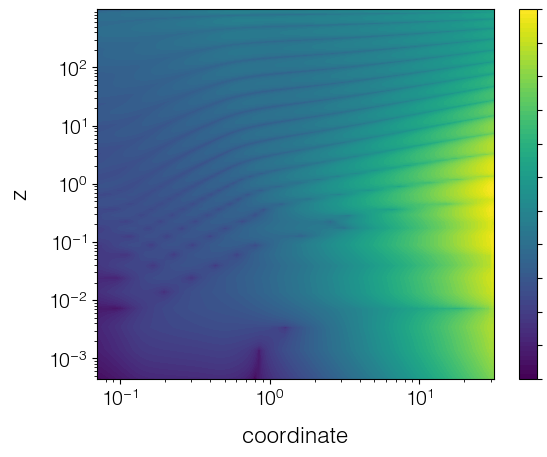

In [32]:
eigencharges = GS.get_eigencharges_AWA(Nmodes=Nmodes_enc)
np.abs(eigencharges[-1]).plot(plotter=plt.contourf,log_scale=True)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [34]:
kwargs = copy.copy(encoding_kwargs)
kwargs['Nmodes']=Nmodes_enc
kwargs['kappa_max']=np.inf
Enc = GS.Encode(recompute=False,**kwargs)

try: Enc.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid)_EncodedEigenfields.pickle"!
File already exists, no need to save...


### Check uniformity of encoding

In [446]:
zmin,zmax = 0.1,10
at_gaps = np.logspace(np.log(zmin)/np.log(10),
                      np.log(zmax)/np.log(10),200)
#at_gaps = np.linspace(.1,10,200) #Doesn't matter, result is robust

Phi0Vecs = np.array(Enc.Phi0Vecs) #column vectors of scalar field vs kappa
BVecs = Enc.BVecs(*at_gaps)
PsiMats = Enc.PsiMats(*at_gaps)
PoleMats = Enc.PoleMats(*at_gaps)

vecs = []
for i,gap in enumerate(at_gaps):
    PoleMat = PoleMats[i]
    PsiMat = PsiMats[i]
    BVec = BVecs[i]
    PoleMatInv = np.diag(1/np.diag(PoleMat))
    # The idea is that radiance vector annhilates eigenfield index,
    # leaving row vector `vec` with columns labeled by q
    # (these q label rows of `Phi0Vecs`, and columns of `Phi0Vecs.T`)
    vec = (BVec.T @ PoleMatInv @ PsiMat.T @ Phi0Vecs.T) # row vector in q, squared
    # We would now have first-order signal:  `Erad = vec @ diag(rp*dkappas) @ vec.T`
    vecs.append( vec.squeeze()**2*Enc.dkappas )

vecs = AWA(vecs,axes=[at_gaps,Enc.kappas],axis_names=['z','q'])

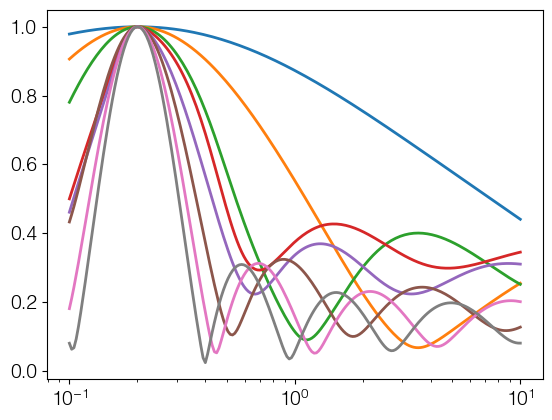

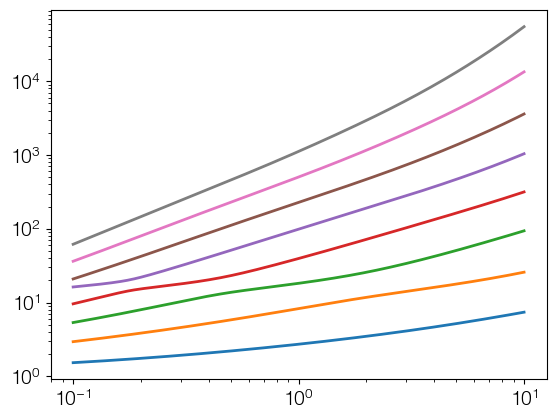

In [447]:
for N in np.arange(0,8):
    plt.figure(1)
    plt.semilogx(at_gaps,np.abs(PsiMats[:,N,N]))
    plt.figure(2)
    plt.loglog(at_gaps,np.abs(PoleMats[:,N,N]))

<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=800...


(1e-07, 1.5)

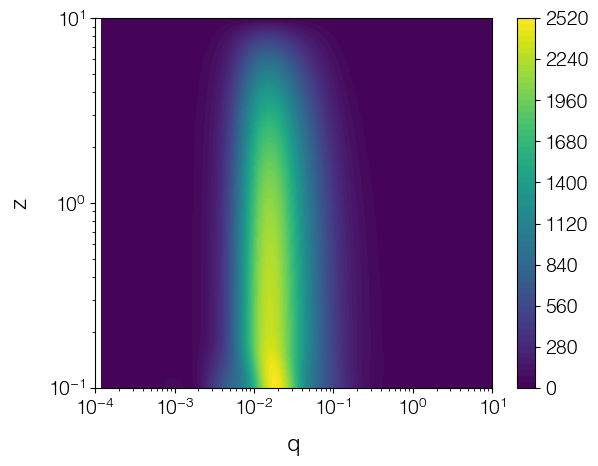

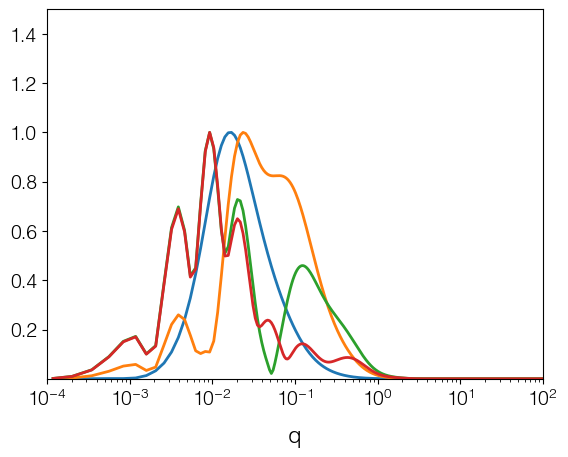

In [449]:
vecs -= vecs[-1][np.newaxis,:]
np.abs(vecs).T.plot(plotter=plt.contourf)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim(1e-4,10)

d = PCE.demodulate(vecs)

plt.figure()
for n in [1,2,3,4]:
    dn=d.cslice[n]
    dn = dn/np.abs(dn).max()
    np.abs(dn).plot()
plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.xlim(1e-4,100)
plt.ylim(1e-7,1.5)

## Parallelized prediction of 2D reflectivity

In [433]:
reload(PS)
kwargs = copy.copy(encoding_kwargs)
kwargs['Nmodes']=Nmodes_enc
kwargs['kappa_max']=np.inf
Enc = GS.Encode(recompute=False,reload=True,**kwargs)

#Enc.build_Rmat2D_library(qps=np.logspace(-3, 2, 50))

try: Enc.save(overwrite=False)
except OSError: print('File already exists, no need to save...')

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid)_EncodedEigenfields.pickle"!
File already exists, no need to save...


In [102]:
from NearFieldOptics import Materials as M
freqs = np.linspace(600,1500,100)
epss = M.SiO2_300nm.epsilon(freqs)

zmin=.1; A=5
at_gaps = np.linspace(zmin,zmin+2*A,100)

for qp in np.logspace(-3,1,10):
    print('qp=%s'%qp)
    erads = []
    for i,eps in enumerate(epss):
        p = i/len(epss)*100
        print('Progress=%i%%'%p,end='\r',flush=True)
        R0 = Enc.interpolate_Rmat2D_from_library(qp, eps)
        erad = Enc.EradVsGap(at_gaps, freq=Enc.get_probe().get_freq(), RMat0=R0)
        #erad = Enc.EradVsGap(at_gaps, freq=Enc.get_probe().get_freq(), rp=(eps-1)/(eps+1))
        erads.append(erad)
    
    erads = AWA(erads,axes=[freqs,at_gaps],axis_names=['Freq','gap'])
    #np.abs(erads).plot()
    Sns[qp] = PCE.demodulate(erads.T)

qp=0.001
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=0.0027825594022071257
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=0.007742636826811269
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=0.021544346900318832
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=0.05994842503189409
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=0.1668100537200059
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=0.46415888336127775
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=1.2915496650148828
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=3.593813663804626
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...
qp=10.0
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=5 with Nt=400...


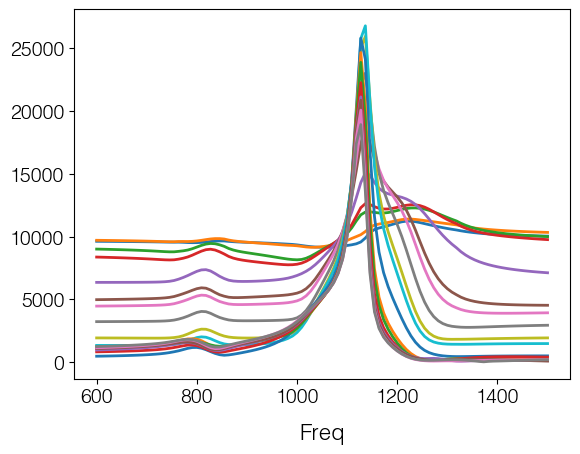

In [103]:
qps = sorted(list(Sns.keys()))
for qp in qps:
    np.abs(Sns[qp].cslice[3]).plot(label=qp)
#plt.legend(title='qp')

In [434]:
class S_vs_qp_predictor(object):

    def __init__(self, Enc,
                 zmin=.1, A=2, Nts=24,
                 harmonic=2,
                Sref=1):

        self.ts,self.dts=numrec.GetQuadrature(N=Nts,xmin=-.5,xmax=0,
                                              quadrature=numrec.GL)
        self.kernel = np.cos(2*np.pi*harmonic*self.ts) * self.dts
        self.kernel -= np.mean(self.kernel)
        
        self.at_gaps = zmin + A*(1+np.cos(2*np.pi*self.ts))
        self.freq = Enc.get_probe().get_freq()
        self.Enc = Enc
        self.Sref = Sref

    def __call__(self, qp, eps):

        R0 = self.Enc.interpolate_Rmat2D_from_library(qp, eps)
        erad_vs_gap = self.Enc.EradVsGap(self.at_gaps, freq=self.freq,
                                         RMat0=R0, as_AWA = False )

        # here is the demodulation!
        erad_vs_gap = np.array(erad_vs_gap)
        Sn = 4 * np.sum( self.kernel * erad_vs_gap, axis=0)

        return complex(Sn/self.Sref)
        
def residual(args,Stargetr,Stargeti,Spredictor,eps,exp=1):

    Starget = Stargetr+1j*Stargeti
    qpr,qpi = args
    qp = qpr+1j*np.abs(qpi)

    diff = Starget - Spredictor(qp,eps)
    diffr = float(diff.real)
    diffi = float(diff.imag)
    #return np.abs(Starget - Spredictor(qp))**exp
    return np.abs(np.array((diffr,diffi)))**exp

In [407]:
harmonic = 2
zmin = 0.1
A=4
Sref = Enc.EradDemodulated2DFromLibrary(qp=1e3,eps=1e3,zmin=zmin,A=A)['Sn'][harmonic]

eps = 2
qp_actual = .5+.1j

Spredictor = S_vs_qp_predictor(Enc,
                               harmonic=harmonic,Nts=48,
                               A=A,zmin=zmin,
                               Sref=Sref)
Starget = Spredictor(qp_actual,eps)

exp=1
x0 = (.1,.1)
#Starget = 1.+0j

t0 = time.time()
result = leastsq(residual,x0, args=(Starget.real,Starget.imag,
                                    Spredictor,eps,exp),
                 factor=0.1,full_output=False, xtol = 1e-20, ftol=1e-20)[0]
print('Elapsed:',time.time()-t0)
qp_predicted = result[0]+1j*result[1]

print('qp Actual:',qp_actual)
print('qp Predicted:',qp_predicted)

print('S actual:',Spredictor(qp_actual,eps))
print('S predicted:',Spredictor(qp_predicted,eps))



	Computing at freq=1.600E-03...
<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.EradSpectrumDemodulated>:
	Demodulating...
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=2 with Nt=96...
		Time elapsed: 0.010568857192993164
Elapsed: 0.30948305130004883
qp Actual: (0.5+0.1j)
qp Predicted: (0.499999999954135+0.10000000002038913j)
S actual: (0.04669290503609282+0.018243299559967213j)
S predicted: (0.04669290503988747+0.01824329957249407j)


	Computing at freq=1.600E-03...
<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.EradSpectrumDemodulated>:
	Demodulating...
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=2 with Nt=96...
		Time elapsed: 0.009800910949707031


Text(0.5, 1.0, 'Qp')

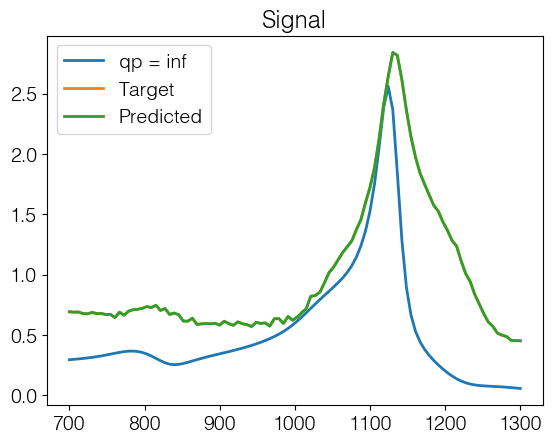

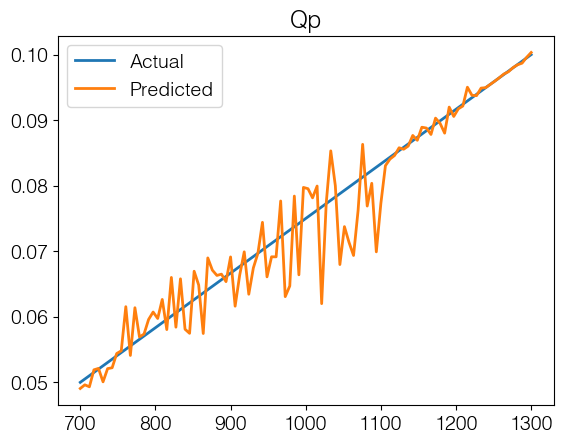

In [440]:
freqs = np.linspace(700,1300,100)
epss = M.SiO2_300nm.epsilon(freqs)

harmonic = 2
zmin = 0.1
A=4
Sref = Enc.EradDemodulated2DFromLibrary(qp=1e3,eps=1e3,zmin=zmin,A=A)['Sn'][harmonic]
Spredictor = S_vs_qp_predictor(Enc,
                               harmonic=harmonic,Nts=48,
                               A=A,zmin=zmin,
                               Sref=Sref)
S0 = [Spredictor(1e3,eps) for eps in epss]
S0 = np.array(S0)

Q=5
qps_actual = np.linspace(.05,0.1,len(freqs))*(1+1j/Q)
Stargets = [Spredictor(qp_actual,eps) for qp_actual,eps in zip(qps_actual,epss)]
Stargets = np.array(Stargets)

# Add noise
n=0.02
Stargets += n*np.random.randn(len(freqs))

exp=1
qps_pred = []
qp_pred = 0.1+.1j
for freq,eps,Starget in zip(freqs,epss,Stargets):
    t0 = time.time()
    x0 = (qp_pred.real,qp_pred.imag)
    result = leastsq(residual,x0, args=(Starget.real,Starget.imag,
                                        Spredictor,eps,exp),
                     factor=0.1,full_output=False, xtol = 1e-20, ftol=1e-20)[0]
    print('freq=%1.2f'%freq,'; Elapsed: %1.3f'%(time.time()-t0),
          end='\r',flush=True)
    qp_pred = result[0]+1j*result[1]
    qps_pred.append(qp_pred)
    
qps_pred = np.array(qps_pred)
Spreds = [Spredictor(qp_pred,eps) for qp_pred,eps in zip(qps_pred,epss)]

plt.figure()
plt.plot(freqs,np.abs(S0),label='qp = inf')
plt.plot(freqs,np.abs(Stargets),label='Target')
plt.plot(freqs,np.abs(Spreds),label='Predicted')
plt.legend()
plt.title('Signal')

plt.figure()
plt.plot(freqs,qps_actual.real,label='Actual')
plt.plot(freqs,qps_pred.real,label='Predicted')
plt.legend()
plt.title('Qp')

In [893]:
kappas = Enc.kappas
dkappas = Enc.dkappas
Phi0Vecs = Enc.Phi0Vecs #column vectors of scalar field vs kappa

freq = Enc.Probe.get_freq()
#k = 2 * np.pi * freq
#light_cone_buffer = Enc.Probe.light_cone_buffer # a class attribute
#qs = np.sqrt(k ** 2 + kappas ** 2).real #This will keep us out of the light cone
qs = kappas

def get_rps(q):

    # Substrate part, then 2D part
    return (1)/(1-q),\
            (-q)/(1-q)

def getRmats(qp):
        
    global qs,Phi0Vecs,dkappas
    rp1_vs_q,rp2_vs_q = get_rps(qs/qp)
    R1 = Phi0Vecs.T @ np.diag(dkappas * rp1_vs_q) @ Phi0Vecs
    R2 = Phi0Vecs.T @ np.diag(dkappas * rp2_vs_q) @ Phi0Vecs
    return R1,R2

Nmodes = len(Enc.Phis0)
print('Nmodes=%i'%Nmodes)
Npts = 100
print('Computing response from %i eigenfields to %i x %i qp values...'%(Nmodes,Npts,Npts))
qps_amp = np.logspace(-3,2,Npts)
qps_phase = np.linspace(0,2*np.pi,2*Npts+2)[1:2*Npts+1] 
RMats1 = np.zeros([len(qps_amp),
                   len(qps_phase),
                    Nmodes,Nmodes],
                      dtype=complex)
RMats2 = np.zeros([len(qps_amp),
                   len(qps_phase),
                    Nmodes,Nmodes],
                      dtype=complex)

for i,qp_amp in enumerate(qps_amp):
    print('i=%i'%i)
    for j,qp_phase in enumerate(qps_phase):
        qp = qp_amp * np.exp(1j*qp_phase)
        R1,R2 = getRmats(qp)
        RMats1[i,j]=R1
        RMats2[i,j]=R2

axes = [qps_amp,qps_phase,None,None]
axis_names = ['Abs(qp)','Arg(qp)',None,None]
RMats1 = AWA(RMats1,axes=axes,axis_names=axis_names)
RMats1 = RMats1.sort_by_axes()
RMats2 = AWA(RMats2,axes=axes,axis_names=axis_names)
RMats2 = RMats2.sort_by_axes()


Nmodes=15
Computing response from 15 eigenfields to 100 x 100 qp values...
i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9
i=10
i=11
i=12
i=13
i=14
i=15
i=16
i=17
i=18
i=19
i=20
i=21
i=22
i=23
i=24
i=25
i=26
i=27
i=28
i=29
i=30
i=31
i=32
i=33
i=34
i=35
i=36
i=37
i=38
i=39
i=40
i=41
i=42
i=43
i=44
i=45
i=46
i=47
i=48
i=49
i=50
i=51
i=52
i=53
i=54
i=55
i=56
i=57
i=58
i=59
i=60
i=61
i=62
i=63
i=64
i=65
i=66
i=67
i=68
i=69
i=70
i=71
i=72
i=73
i=74
i=75
i=76
i=77
i=78
i=79
i=80
i=81
i=82
i=83
i=84
i=85
i=86
i=87
i=88
i=89
i=90
i=91
i=92
i=93
i=94
i=95
i=96
i=97
i=98
i=99


In [894]:
# Build an interpolator based on the numerically computed values
from scipy.interpolate import RectBivariateSpline as RBS

R1_interp_r={}
R1_interp_i={}
R2_interp_r={}
R2_interp_i={}
pts = RMats1.axes[:2]
kwargs=dict(s=1)
for i in range(RMats1.shape[2]):
    for j in range(RMats1.shape[2]):
        inds = (i,j)
        if j>i: continue
        R1_interp_r[inds] = RBS(*pts,RMats1[:,:,i,j].real,**kwargs)
        R1_interp_i[inds] = RBS(*pts,RMats1[:,:,i,j].imag,**kwargs)
        R2_interp_r[inds] = RBS(*pts,RMats2[:,:,i,j].real,**kwargs)
        R2_interp_i[inds] = RBS(*pts,RMats2[:,:,i,j].imag,**kwargs)

def R_interpolator(qp,eps):

    kappa = (eps+1)/2
    beta = (eps-1)/(eps+1)
    qp_eff = kappa * qp

    q1 = np.abs(qp_eff)
    q2 = np.angle(qp_eff)

    RMat=np.zeros(RMats1.shape[2:],
               dtype=complex)
    for  i in range(RMat.shape[0]):
        for j in range(RMat.shape[1]):
            inds = (i,j)
            if j>i: continue

            # Substrate part
            R1 = R1_interp_r[inds](q1,q2,grid=False) \
                    + 1j*R1_interp_i[inds](q1,q2,grid=False)
            R1 *= beta
            
            # 2D part
            R2 = R2_interp_r[inds](q1,q2,grid=False) \
                    + 1j*R2_interp_i[inds](q1,q2,grid=False)

            RMat[i,j] = RMat[j,i] = R1+R2

    return RMat
    
print( R_interpolator(1,1))

[[-0.02048061+0.74309584j -0.43159704-0.53937921j  0.39364223-0.15247827j
  -0.06495784-0.19594866j  0.14458016+0.20068492j -0.24462958+0.21846868j
  -0.21482692-0.29773579j -0.32417695+0.2117232j  -0.15648011-0.28141167j
  -0.26398979+0.08464826j -0.0533866 -0.2074962j  -0.2047111 +0.03110763j
   0.01720654+0.20422307j  0.31698345-0.01404282j  0.03201694+0.34330972j]
 [-0.43159704-0.53937921j  0.75577939+0.56833639j -0.58041666+0.00824554j
   0.00810405+0.21533911j -0.09058356-0.27581628j  0.36488556-0.16717845j
   0.16571849+0.38931244j  0.37773387-0.12752272j  0.09506208+0.37551885j
   0.31132739-0.00537912j -0.02922267+0.2440384j   0.27446667+0.04863498j
   0.0685439 -0.31258386j -0.33670208-0.07409866j  0.05653441-0.3886503j ]
 [ 0.39364223-0.15247827j -0.58041666+0.00824554j  0.57343123+0.23886974j
   0.28649499+0.04271204j -0.21790168+0.02709313j -0.09796077-0.25503294j
   0.27756517-0.07616473j -0.05810691-0.26075665j  0.23771992-0.02547734j
   0.00839695-0.2173917j   0.2101665

In [899]:
qps = np.logspace(-3,1,200)*(1+1j/100)
Rs = [R_interpolator(qp,1) for qp in qps]
S1s=[]
S2s=[]
S3s=[]
S4s=[]
S5s=[]
kwargs=dict(amplitude=1,Ngaps=48,gapmin=0.071)
for R in Rs:
    result = Enc.EradSpectrumDemodulated(freqs=Enc.Probe.get_freq(),
                                         RMat0=R,**kwargs)['Sn']
    print(result[2].shape)
    S1s.append(result[1])
    S2s.append(result[2])
    S3s.append(result[3])
    S4s.append(result[4])
    S5s.append(result[5])

S1s = AWA(S1s,axes=[qps.real],axis_names=['qp'])
S2s = AWA(S2s,axes=[qps.real],axis_names=['qp'])
S3s = AWA(S3s,axes=[qps.real],axis_names=['qp'])
S4s = AWA(S4s,axes=[qps.real],axis_names=['qp'])
S5s = AWA(S5s,axes=[qps.real],axis_names=['qp'])

S0 = Enc.EradSpectrumDemodulated(freqs=Enc.Probe.get_freq(),
                                 rp=1,**kwargs)['Sn']
S1s/=S0[1]
S2s/=S0[2]
S3s/=S0[3]
S4s/=S0[4]
S5s/=S0[5]

	Computing at freq=1.600E-03...
<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.EradSpectrumDemodulated>:
	Demodulating...
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=1 with Nt=192...
		Time elapsed: 0.07676410675048828
(1,)
	Computing at freq=1.600E-03...
<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.EradSpectrumDemodulated>:
	Demodulating...
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=1 with Nt=192...
		Time elapsed: 0.06639695167541504
(1,)
	Computing at freq=1.600E-03...
<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.EradSpectrumDemodulated>:
	Demodulating...
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=1 with Nt=192...
		Time elapsed: 0.0689997673034668
(1,)
	Computing at freq=1.600E-03...
<ProbeCavityEigenfields.ProbeSpectroscopy.EncodedEigenfields.EradSpectrumDemodulated>:
	Demodulating...
<ProbeCavityEigenfields.demodulate>:
	Demodulating across A=1 with Nt=192...
		Time elapsed: 0.07123184

(0.0, 1.5)

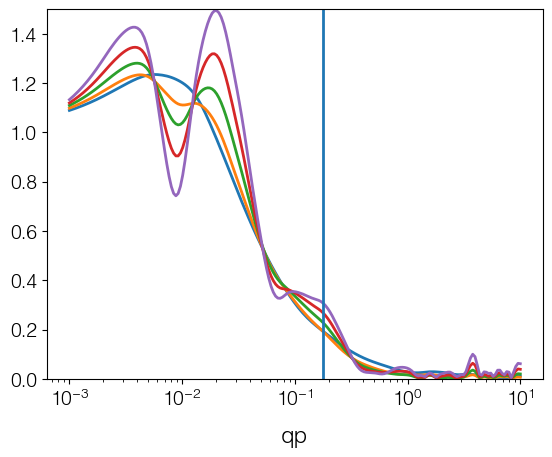

In [900]:
for val in S1s,S2s,S3s,S4s,S5s:
    #val = val/np.abs(val).max()
    np.abs(val).squeeze().plot(plotter=plt.semilogx)
plt.axvline(2*np.pi/35)
plt.ylim(0,1.5)

## Fit the eigenpotential spectrum with (real) monopoles

In [418]:
Nmode=10
Phi = Enc.Phis0[Nmode-1]  # If we fit this, we are implicitly finding the sum of monopole potentials $\exp(-q*Z)/q$
Phi = AWA(Phi, axes=[Enc.kappas])

#--- We can reliably get q-(abscissa) and potential values from extrema of eigenmode
#extrema = num.extrema(P.real)
#qs0 = [coord[0] for coord in extrema['maxima']['coordinates']]
#qs0 = np.append(qs0, [coord[0] for coord in extrema['minima']['coordinates']])
#ys = [P[i] for i in extrema['maxima']['indices']]
#ys = np.append(ys, [P[i] for i in extrema['minima']['indices']])

#qs0 = np.logspace(-4,1,2*Nmode)
qs0 = np.logspace(-4,1,Nmode+2)
ys = np.array([Phi.cslice[q0] for q0 in qs0])

#--- We built guess monopole parameters in correspondence to the extrema (plus one)
Zs0 = 1/qs0
#Zs0 = np.append(Zs0.max()*5,Zs0)
Qs0 = ys
#Qs0 = np.append(P[0],ys)
params0 = np.hstack((Qs0.real,Qs0.imag,Zs0))
print('N monopoles:',len(Zs0))

from numba import njit

@njit
def unpack_params(params):

    N = len(params)//3
    Qs =[]; Zs=[]
    for i in range(N):
        Qs.append(params[i] + params[N+i]*1j)
        Zs.append(params[2*N+i])
    return Qs,Zs

kappas=Enc.kappas
@njit
def cook_model(params):

    resultr = np.zeros(kappas.shape,dtype=float)
    resulti = np.zeros(kappas.shape,dtype=float)
    N = len(params)//3
    for i in range(N):
        Qr = params[i]
        Qi = params[N+i]
        Z=params[2*N+i]
        exp = np.exp(-Z*kappas)
        resultr += Qr*exp
        resulti += Qi*exp
    return resultr + 1j*resulti

def residual(params):

    model = cook_model(params)

    return np.abs(model-np.array(Phi)).astype(float)**2*Enc.dkappas

def get_R2(params):

    norm = np.sum(np.abs(Phi)**2*Enc.dkappas)
    res = residual(params)
    return float(np.sum(res)/norm)

from scipy.optimize import leastsq

#--- We can iterate fit an indefinite number of types, cycling between residual exponents
# Add some randomization to avoid trapping
R2=1; i=0; exps = np.linspace(1,0.25,10)
randomization = .1
R2_target = 0.05; max_iter = 100
fits = {}
while R2>R2_target or i>max_iter:
    exp = exps[i % len(exps)]
    fit = leastsq(lambda params,exp: residual(params)**exp,
                  params0, args=(exp,),
                  factor=100)[0]
    R2 = get_R2(fit)
    print('R2 value:',R2)
    fits[R2] = fit
    params0 = fit*(1+randomization*np.random.randn(len(params0)))
    i+=1

N monopoles: 12
R2 value: 0.6181793473029693
R2 value: 0.4862150001177497
R2 value: 0.44141954940253936
R2 value: 0.40020684610880347
R2 value: 0.3702622363327289
R2 value: 0.34208380412755063
R2 value: 0.32959610842777165
R2 value: 0.32377748274416035
R2 value: 0.329032018426328
R2 value: 0.3412774561218496
R2 value: 0.3427506512337665
R2 value: 0.3329921058816488
R2 value: 0.3283953261171673
R2 value: 0.32327786436643574
R2 value: 0.31437668404952185
R2 value: 0.30907785988876385
R2 value: 0.3034409714097114
R2 value: 0.3013638430911008
R2 value: 0.30492263222328636
R2 value: 0.3187838919303529
R2 value: 0.32305154895053045
R2 value: 0.31970144025054276
R2 value: 0.3168422727103397
R2 value: 0.32716888502533703
R2 value: 0.3084065437023638
R2 value: 0.3411094236187662
R2 value: 0.3126438281345803
R2 value: 0.3034289444320784
R2 value: 0.29791972144146656
R2 value: 0.3228781203422289
R2 value: 0.30783336351555757
R2 value: 0.3382493784050847
R2 value: 0.3080373086864273
R2 value: 0.32

KeyboardInterrupt: 

> /var/folders/67/32mwwcnj2pl1mtqhfc7mzlz80000gn/T/ipykernel_86358/716580764.py(74)<lambda>()
     72 while R2>R2_target or i>max_iter:
     73     exp = exps[i % len(exps)]
---> 74     fit = leastsq(lambda params,exp: residual(params)**exp,
     75                   params0, args=(exp,),
     76                   factor=100)[0]

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


ipdb>  exit


Normalization factor: (1.0525373767528052+0.04258987957627009j)


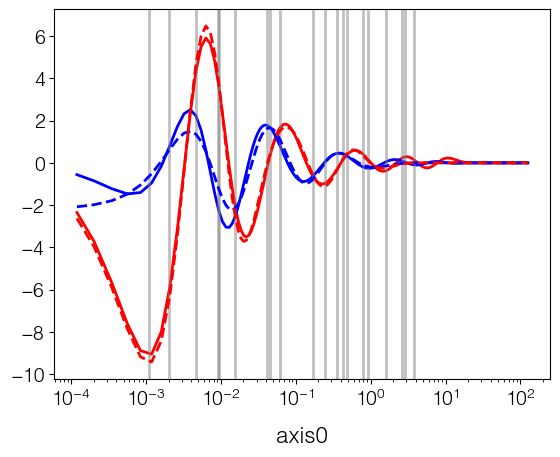

In [100]:
Phi.real.plot(color='r')
Phi.imag.plot(color='b')
plt.gca().set_xscale('log')

#Qs,Zs = unpack_params(fit)
for Z in Zs: plt.axvline(1/Z,alpha=.5,color='gray')

model = AWA(cook_model(fit),axes=[Enc.kappas])

#this is a normalization factor
R0 = Enc.get_2D_reflectivity_from_monopoles(sigma2D=1e8, eps_substrate=1, freq=1, monopoles1=monopoles, numerical=False)
N = 1/np.sqrt(R0)
print('Normalization factor:',N)
model *= N

model.imag.plot(color='b',ls='--')
model.real.plot(color='r',ls='--')

monopoles = (Qs,Zs)

In [177]:
# Check that these integrate to 1
result = 0+0j
for Qi,Zi in zip(*monopoles):
    for Qj,Zj in zip(*monopoles):
        contrib = Qi*Qj/(Zi+Zj)
        result = result + contrib
print(result)

(0.8982400061649969-0.07281360370029688j)


# Prepare PCE Model - long blunt QS ellipsoid

## Build Probe

In [ ]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
geometry='ellipsoid'
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=1000
freq_THz=a_nm/WL_THz_nm
freq0=24*freq_THz
gap0=0.1

#-- Build probe

Nsubnodes=2
P5=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.GL,\
            a=20,geometry=geometry,freq=freq0,gap=gap0,closed=False,name=geometry+'_long_blunt')

In [ ]:
#-- Plot probe shape

P5.plot_geometry(ms=1)


P5.plot_geometry(ms=4)
plt.xlim(-3,3)
plt.ylim(-1,5)

In [ ]:
gap=4
P5.set_gap(gap)
P5.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
                       Nkappas=244*4,kappa_max=10,kappa_min=None,qquadrature=numrec.GL)
P5.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
P5.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
P5.plot_eigenrhos()

## Probe spectroscopy

In [ ]:
#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

gaps = np.logspace(-1.5,1,400)

geometry='ellipsoid_long_blunt'
@misc.autopickle('Probe Models/ProbeGapSpectroscopy_geometry=%s.pickle'%(geometry))
def getGapSpectroscopy5(gaps=gaps, Nmodes=20):
    
    P=P5
    P.set_freq(0)
    print('Computing at frequency =',freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=20,sommerfeld=True,\
                           Nkappas=244*4,qquadrature='GL')
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True,Nmodes=Nmodes) #This happens automatically
    
    return GS

@misc.autopickle('Probe Models/ProbeEncoding_geometry=%s.pickle'%(geometry))
def getProbeEncoding5(GapSpectroscopy,gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*10,kappa_min=None,):

    GapSpectroscopy.get_probe().set_freq(freq0)
    enc = PS.EncodedEigenfields(GapSpectroscopy,gap0=gap0,Nmodes=Nmodes,\
                                Nkappas=Nkappas,kappa_max=kappa_max,kappa_min=kappa_min)
    
    return enc

In [ ]:
GS5 = getGapSpectroscopy5(recompute=False,overwrite=False,reload=True)
Nmodes=25
GS5(Nmodes=Nmodes,by_rho=True,reversed=True,debug=False)
GS5.plot_eigenrhos(Nmodes=Nmodes,recompute=True)
plt.gcf().axes[0].set_xlabel('Gap')

# Compare probes

## Eigenrhos at z=a/2

<ProbeCavityEigenfields._ProbesCollection.__setitem__>:
	Overwriting registered probe "hyperboloid"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid)_ProbeGapSpectroscopy.pickle"!


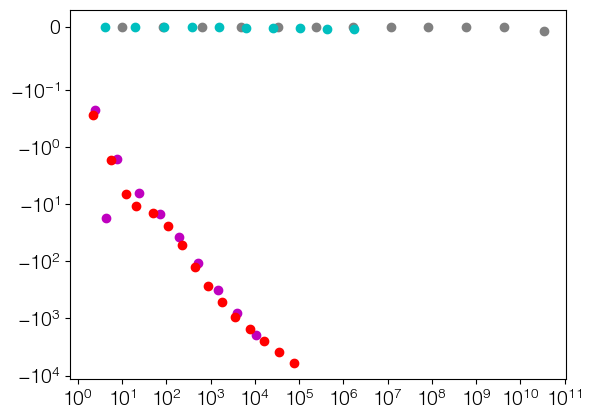

In [770]:
rhos = get_probe('sphere').gapSpectroscopy().get_eigenrhos_AWA().cslice[:,.5]
plt.scatter(rhos.real,rhos.imag,marker='o',color='gray')
rhos = get_probe('ellipsoid').gapSpectroscopy().get_eigenrhos_AWA().cslice[:,.5]
plt.scatter(rhos.real,rhos.imag,marker='o',color='c')
rhos = get_probe('ellipsoid_long').gapSpectroscopy().get_eigenrhos_AWA().cslice[:,.5]
plt.scatter(rhos.real,rhos.imag,marker='o',color='m')
rhos = get_probe('hyperboloid').gapSpectroscopy().get_eigenrhos_AWA().cslice[:,.5]
plt.scatter(rhos.real,rhos.imag,marker='o',color='r')
plt.gca().set_xscale('symlog',linthresh=.1)
plt.gca().set_yscale('symlog',linthresh=.1)

## Approach curves

In [417]:
beta=.05
A=1
zmin,zmax=0.1,5
harmonic=2
at_gaps = np.linspace(zmin,zmax,50)
gaps_demod=np.linspace(0,2*A,20)


approaches = {}
for geometry in ['ellipsoid','ellipsoid_long','hyperboloid']:
    P = get_probe(geometry)
    Enc = PCE.load(P,PS.EncodedEigenfields)
    print(Enc.Poles.shape)
    erads = Enc.EradVsGap(at_gaps, freq=.001,rp=beta)
    z0s = at_gaps[at_gaps<=zmax-2*A]
    sns=[]
    for z0 in z0s:
        erads_interp = erads.interpolate_axis(z0+gaps_demod,
                                              axis=0)
        sn = PCE.demodulate(erads_interp).cslice[harmonic]
        sns.append(sn)
    sns = AWA(np.array(sns),axes=[z0s])
    sns  /= np.abs(sns).max()
    approaches[geometry]=sns

geometry='hyperboloid_blunt'
approaches[geometry] = get_probe(geometry,reload=True).EradApproachCurveDemodulated(freq=None, gaps=at_gaps, amplitude=A,
                                                                     Nzs_demod=12, zquadrature=numrec.CC,
                                                                     Nmodes=Nmodes_enc, illum_angles=None,
                                                                     rp=beta, recompute_rp=True, demod_order=4,
                                                                     recompute_propagators=True,
                                                                     recompute_brightness=True)['Sn'][harmonic]


Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid)_EncodedEigenfields.pickle"!
(331, 10)
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(ellipsoid_long)_EncodedEigenfields.pickle"!
(400, 15)
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid)_EncodedEigenfields.pickle"!
(490, 15)
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid_blunt)_Probe.pickle"!
<ProbeCavityEigenfields.Probe.EradApproachCurveDemodulated>:
	Building approach curve...
	Working on z=0.10...
<ProbeCavityEigenfields.Probe.get_eigenbrightness>:
	Computing eigenbrightness at k=0.01...
<ProbeCavityEigenfields.Probe.EradVsGap>:
	Computing response for gaps at freq=0.001...
<ProbeCavityEigenfields.Probe.getFourPotentialPropagators>:
	Computing field propagators at k=0...
	I

In [ ]:
for geometry in approaches:
    ac = approaches[geometry]
    (np.abs(ac)/np.abs(ac).max()).plot(label=geometry)
plt.legend()

(1, 1000.0)

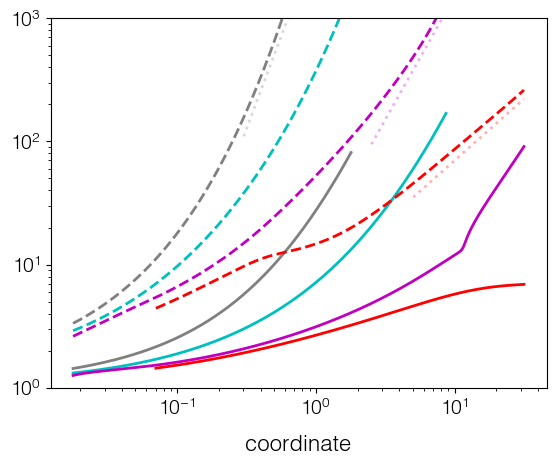

In [822]:
rhos = get_probe('sphere').gapSpectroscopy().get_eigenrhos_AWA().cslice[0]
gaps = rhos.axes[0]; gaps=gaps[gaps>.3]
plt.plot(gaps,4000*gaps**3,ls=':',alpha=.3,color='gray')
rhos.plot(color='gray')
rhos = get_probe('ellipsoid').gapSpectroscopy().get_eigenrhos_AWA().cslice[0]
rhos.plot(color='c')
rhos = get_probe('ellipsoid_long').gapSpectroscopy().get_eigenrhos_AWA().cslice[0]
gaps = rhos.axes[0]; gaps=gaps[gaps>2.5]
rhos.plot(color='m')
plt.plot(gaps,15*gaps**2,ls=':',alpha=.3,color='m')
rhos = get_probe('hyperboloid').gapSpectroscopy(reload=False).get_eigenrhos_AWA().cslice[0]
gaps = rhos.axes[0]; gaps=gaps[gaps>5]
rhos.plot(color='r')
plt.plot(gaps,7*gaps,ls=':',alpha=.3,color='r')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

N=2
rhos = get_probe('sphere').gapSpectroscopy().get_eigenrhos_AWA().cslice[N]
rhos.plot(color='gray',ls='--')
rhos = get_probe('ellipsoid').gapSpectroscopy().get_eigenrhos_AWA().cslice[N]
rhos.plot(color='c',ls='--')
rhos = get_probe('ellipsoid_long').gapSpectroscopy().get_eigenrhos_AWA().cslice[N]
rhos.plot(color='m',ls='--')
rhos = get_probe('hyperboloid').gapSpectroscopy(reload=False).get_eigenrhos_AWA().cslice[N]
rhos.plot(color='r',ls='--')
plt.ylim(1,1e3)

* Blunt probes are hard to calculate, as they require many modes to capture the physics (30 for the blunt ellipsoid!)
* Approach curves indeed show that a probe is 10x more blunt... but only when reflection coefficient is small (.1)
* At larger reflection coefficient, there is "merging" onto a common curve that is logarithmic in distance.
* Larger reflection engages higher order modes, which are more delocalized (lower momentum)..
    * But why logarithmic?

In [ ]:
P5 = GS5.get_probe_at_coord(1)
Phi,Az,Ar,Ez=P5.getFourPotentialAtZ(k=0,rs=np.logspace(-.5,2.5,200))
for ei in range(5):
    np.abs(Phi[ei]).plot(label=ei)

#plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.ylim(5e-3,.5)
plt.legend(title='Eigenfield #')

## SiC spectroscopy

In [ ]:
sic0 = P4.getNormalizedSignal(freqs_wn_sic,rp=M.SiC_6H.reflection_p,
                                a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                Ngaps=24,Nkappas=244,gapmin=gapmin,
                                rp_norm = M.Si.reflection_p,
                                freqs_wn_norm = None)

In [ ]:
from NearFieldOptics import Materials as M
Ngaps=24*8
sic1 = Encoding.getNormalizedSignal(freqs_wn_sic,rp=M.SiC_6H.reflection_p,
                                        a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=Ngaps,gapmin_nm=gapmin_nm,
                                        rp_norm = M.Si.reflection_p)
sic2 = Encoding.getNormalizedSignal(freqs_wn_sic,rp=M.SiC_6H.reflection_p,
                                        a_nm=a_nm*.6,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=Ngaps,gapmin_nm=a_nm/10,
                                        rp_norm = M.Si.reflection_p) # 12nm probe radius, close to sample as reasonable
"""si = Encoding.getNormalizedSignal(freqs_wn,rp=M.Si.reflection_p,
                                        a_nm=a_nm,amplitude_nm=80,demod_order=5,
                                        Ngaps=24*4,gapmin_nm=gapmin_nm,
                                        rp_norm = None)
au = Encoding.getNormalizedSignal(freqs_wn,rp=M.Au.reflection_p,
                                        a_nm=a_nm,amplitude_nm=80,demod_order=5,
                                        Ngaps=24*4,gapmin_nm=gapmin_nm,
                                        rp_norm = None)"""

In [ ]:
angle=50; dangle=15
angles = np.linspace(angle-dangle/2,angle+dangle/2,20)
R = np.mean([M.SiC_6H.reflection_p(freqs_wn_sic,angle=angle) for angle in angles],axis=0)
R0 = np.mean([M.Si.reflection_p(freqs_wn_sic,angle=angle) for angle in angles],axis=0)
f=0.8*np.exp(1j*np.pi/2*.7) #This is a little fine-tuned for the existing data
FFF=(1+f*R)**2/(1+f*R0)**2
#FFF=1

signal0 = sic0['Sn'][3]
signal1 = sic1['Sn'][3]
signal2 = sic2['Sn'][3]

np.abs(signal0*FFF).plot()
np.abs(signal1*FFF).plot()
np.abs(signal2*FFF).plot()
#plt.ylim(0,5)
plt.axhline(.5)
plt.xticks((600,800,900,1000,1100))
plt.xlim(700,1100)
plt.grid(ls='--',alpha=.5,color='k')

plt.figure()
plt.plot(freqs_wn_sic,np.unwrap(np.angle(signal0*FFF)))
plt.plot(freqs_wn_sic,np.unwrap(np.angle(signal1*FFF)))
plt.plot(freqs_wn_sic,np.unwrap(np.angle(signal2*FFF)))
plt.xlim(700,1100)

![alt text](SiC_ExperimentalS3_80nmTapping_NormSi_WithFarField.png "Title")

In [ ]:
np.abs(c1).plot()
np.abs(c2).plot()
#plt.xticks([0,20,40,60,80,100])
#plt.xlim(0,100)
plt.grid(alpha=.5,color='k')
plt.ylim(0,1.1)
#plt.axhline(.5,color='r')
#plt.axvline(16,color='r')

In [ ]:
np.abs(c1).plot(plotter=plt.semilogx)
np.abs(c2).plot(plotter=plt.semilogx)
plt.semilogx(zs_norm,np.pi/12*(1.2-np.log(zs_norm)),color='r')